In [1]:
#preliminaries
import pandas as pd
import numpy as np

!pip install lifelines
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

%matplotlib inline
import matplotlib.pyplot as plt

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Creating HF tables

In [2]:
cols1 = ['patid', 'date', 'hf_event', 'hf_occur', 'beta_event', 'beta_occur', 'ace_event', 'ace_occur']
hf = pd.read_csv('HF_only_copy.csv', parse_dates=['date'], index_col='date', names=cols1, skiprows=1)
hf.head()

,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur
date,,,,,,,
2015-06-16,454,1,1.0,0,NaN,0,NaN
2015-09-10,454,1,1.0,0,NaN,0,NaN
2016-07-14,454,1,1.0,0,NaN,0,NaN
2017-03-16,454,1,1.0,0,NaN,0,NaN
2017-03-31,454,0,NaN,0,NaN,1,1.0


In [3]:
hf = hf.fillna(0)

In [4]:
hf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044143 entries, 2015-06-16 to 2017-08-29
Data columns (total 7 columns):
patid         1044143 non-null int64
hf_event      1044143 non-null int64
hf_occur      1044143 non-null float64
beta_event    1044143 non-null int64
beta_occur    1044143 non-null float64
ace_event     1044143 non-null int64
ace_occur     1044143 non-null float64
dtypes: float64(3), int64(4)
memory usage: 63.7 MB


In [5]:
hf['patid'].nunique()

24663

In [6]:
hf.head()

,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur
date,,,,,,,
2015-06-16,454,1,1.0,0,0.0,0,0.0
2015-09-10,454,1,1.0,0,0.0,0,0.0
2016-07-14,454,1,1.0,0,0.0,0,0.0
2017-03-16,454,1,1.0,0,0.0,0,0.0
2017-03-31,454,0,0.0,0,0.0,1,1.0


In [7]:
hf_beta = hf.loc[(hf['beta_event'] == 1) & (hf['beta_occur'] == 1.0)]
hf_beta.head()

,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur
date,,,,,,,
2017-04-03,454,0,0.0,1,1.0,0,0.0
2017-05-04,454,0,0.0,1,1.0,0,0.0
2017-05-30,454,0,0.0,1,1.0,0,0.0
2017-06-28,454,0,0.0,1,1.0,0,0.0
2017-07-21,454,0,0.0,1,1.0,0,0.0


In [8]:
hf_ace = hf.loc[(hf['ace_event'] == 1) & (hf['ace_occur'] == 1.0)]
hf_ace.head()

,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur
date,,,,,,,
2017-03-31,454,0,0.0,0,0.0,1,1.0
2017-05-04,454,0,0.0,0,0.0,1,1.0
2017-05-30,454,0,0.0,0,0.0,1,1.0
2017-06-28,454,0,0.0,0,0.0,1,1.0
2017-07-21,454,0,0.0,0,0.0,1,1.0


In [9]:
hf_beta = hf_beta.reset_index()
hf_beta.head()

,date,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur
0,2017-04-03,454,0,0.0,1,1.0,0,0.0
1,2017-05-04,454,0,0.0,1,1.0,0,0.0
2,2017-05-30,454,0,0.0,1,1.0,0,0.0
3,2017-06-28,454,0,0.0,1,1.0,0,0.0
4,2017-07-21,454,0,0.0,1,1.0,0,0.0


In [10]:
hf_ace = hf_ace.reset_index()
hf_ace.head()

,date,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur
0,2017-03-31,454,0,0.0,0,0.0,1,1.0
1,2017-05-04,454,0,0.0,0,0.0,1,1.0
2,2017-05-30,454,0,0.0,0,0.0,1,1.0
3,2017-06-28,454,0,0.0,0,0.0,1,1.0
4,2017-07-21,454,0,0.0,0,0.0,1,1.0


### HF_beta find time

In [11]:
hf_beta2 = hf_beta.copy()

In [12]:
hf_beta_patid2 = hf_beta2.groupby('patid')

In [13]:
results_1 = []

for patid, hf_beta2 in hf_beta_patid2:
    hf_beta2 = hf_beta2.sort_values('date')
    hf_beta2['timeline'] = (hf_beta2.iloc[-1, 0] - hf_beta2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_1.append(pd.unique(hf_beta2[['patid', 'timeline']].values.ravel('K')))  

In [14]:
data_1 = np.asarray(results_1)
hf_beta_time = pd.DataFrame({'patid':data_1[:,0], 'timeline':data_1[:,1]})
hf_beta_time.head()

,patid,timeline
0,454.0,141.0
1,929.0,866.0
2,2280.0,155.0
3,5233.0,705.0
4,7551.0,17.0


In [15]:
hf_beta_time.describe()

,patid,timeline
count,2.449600e+04,24496.000000
mean,7.075757e+06,565.235100
std,4.908451e+06,522.969063
min,4.540000e+02,0.000000
25%,2.835505e+06,133.000000
50%,6.035731e+06,406.000000
75%,1.093924e+07,875.250000
max,1.738369e+07,2183.000000


In [16]:
hf_beta_time_2 = hf_beta_time.loc[hf_beta_time['timeline'] > 790]
hf_beta_time_2.head()

,patid,timeline
1,929.0,866.0
20,31213.0,1150.0
21,31929.0,830.0
31,43313.0,1612.0
37,46868.0,888.0


In [17]:
hf_beta_time_2.nunique()

patid       7008
timeline    1302
dtype: int64

In [18]:
hf_beta_time_2.describe()

,patid,timeline
count,7.008000e+03,7008.000000
mean,6.760987e+06,1269.655251
std,4.780651e+06,358.602144
min,9.290000e+02,791.000000
25%,2.662344e+06,964.000000
50%,5.727068e+06,1195.000000
75%,1.032541e+07,1513.000000
max,1.738308e+07,2183.000000


In [19]:
hf_beta_new = pd.merge(hf_beta, hf_beta_time_2, on=['patid'], how='inner')
hf_beta_new.head()

,date,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur,timeline
0,2015-04-01,929,0,0.0,1,1.0,0,0.0,866.0
1,2015-04-29,929,0,0.0,1,1.0,0,0.0,866.0
2,2015-05-27,929,0,0.0,1,1.0,0,0.0,866.0
3,2015-06-24,929,0,0.0,1,1.0,0,0.0,866.0
4,2015-07-22,929,0,0.0,1,1.0,0,0.0,866.0


In [20]:
type(hf_beta_new)

pandas.core.frame.DataFrame

In [21]:
hf_beta_new_patid = hf_beta_new.groupby('patid')

In [22]:
type(hf_beta_new_patid)

pandas.core.groupby.DataFrameGroupBy

### HF_beta find gaps

In [23]:
results1 = []

for patid, hf_beta in hf_beta_new_patid:
    hf_beta = hf_beta.sort_values('date')
    hf_beta['gap'] = hf_beta.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hf_beta.loc[hf_beta['gap'] > 90]
    
    if gap_find.empty == True:
        hf_beta['gap_find'] = 730 
        hf_beta['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hf_beta['gap_find'] = (gap_find_date - hf_beta.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hf_beta['event'] = 1
        
    results1.append(pd.unique(hf_beta[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [24]:
data1 = np.asarray(results1)
print(data1)

[[929 730 0]
 [31213 595.0 1]
 [31929 730 0]
 ..., 
 [17376703 730 0]
 [17381781 965.0 1]
 [17383080 730 0]]


In [25]:
dataset_hf_beta = pd.DataFrame({'patid':data1[:,0],'gap_find':data1[:,1],'event':data1[:,2] })
dataset_hf_beta.head()

,event,gap_find,patid
0,0,730,929
1,1,595,31213
2,0,730,31929
3,1,388,43313
4,0,730,46868


In [26]:
dataset_hf_beta.describe()

,event,gap_find,patid
count,7008,7008.0,7008
unique,2,976.0,7008
top,0,730.0,501202
freq,5016,5016.0,1


In [27]:
dataset_hf_beta.patid.nunique()

7008

In [28]:
dataset_hf_beta.loc[dataset_hf_beta['gap_find'] < 0]

,event,gap_find,patid


hf_beta: inf


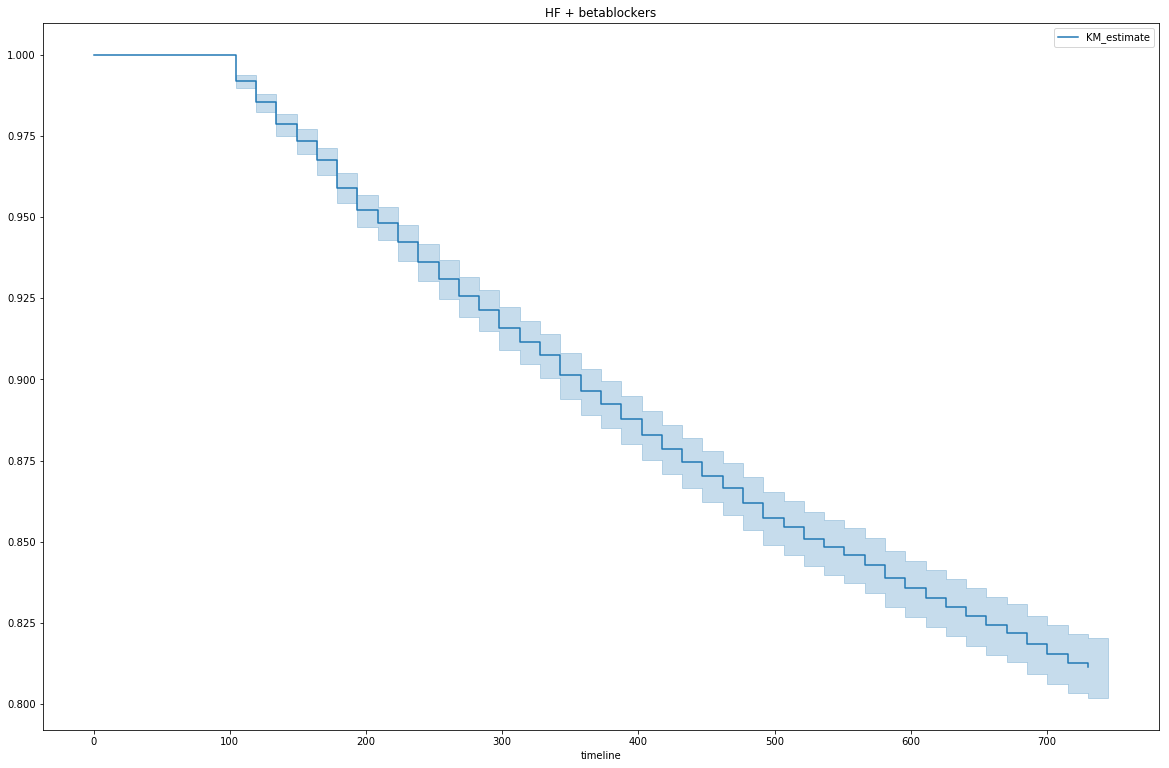

In [29]:
T1 = dataset_hf_beta['gap_find']
E1 = dataset_hf_beta['event']
t = np.linspace(0, 730)

kmf_hf_beta = KaplanMeierFitter()
kmf_hf_beta.fit(T1, event_observed=E1, timeline=t)
print("hf_beta:", kmf_hf_beta.median_)
kmf_hf_beta.plot(title='HF + betablockers')
plt.gcf().set_size_inches(20,13)

In [30]:
kmf_hf_beta.survival_function_ = kmf_hf_beta.survival_function_.reset_index()

In [31]:
type(kmf_hf_beta.survival_function_)

pandas.core.frame.DataFrame

In [32]:
kmf_hf_beta.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.993969,0.989790
119.183673,0.987997,0.982356
134.081633,0.981995,0.975235


In [33]:
kmf_hf_beta_180 = kmf_hf_beta.survival_function_.loc[kmf_hf_beta.survival_function_['timeline'] > 170]
kmf_hf_beta_180

,timeline,KM_estimate
12,178.775510,0.959189
13,193.673469,0.952197
14,208.571429,0.948345
15,223.469388,0.942352
16,238.367347,0.936358
17,253.265306,0.931079
18,268.163265,0.925799
19,283.061224,0.921518
20,297.959184,0.915953
21,312.857143,0.911530


### HF_ace find time

In [34]:
hf_ace2 = hf_ace.copy()

In [35]:
hf_ace_patid2 = hf_ace2.groupby('patid')

In [36]:
results_2 = []

for patid, hf_ace2 in hf_ace_patid2:
    hf_ace2 = hf_ace2.sort_values('date')
    hf_ace2['timeline'] = (hf_ace2.iloc[-1, 0] - hf_ace2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_2.append(pd.unique(hf_ace2[['patid', 'timeline']].values.ravel('K')))  

In [37]:
data_2 = np.asarray(results_2)
hf_ace_time = pd.DataFrame({'patid':data_2[:,0], 'timeline':data_2[:,1]})
hf_ace_time.head()

,patid,timeline
0,454.0,147.0
1,929.0,525.0
2,2280.0,182.0
3,5233.0,0.0
4,7551.0,26.0


In [38]:
hf_ace_time.describe()

,patid,timeline
count,2.441300e+04,24413.000000
mean,7.074743e+06,517.945685
std,4.909930e+06,509.210046
min,4.540000e+02,0.000000
25%,2.829960e+06,107.000000
50%,6.035231e+06,346.000000
75%,1.094347e+07,799.000000
max,1.738369e+07,2183.000000


In [39]:
hf_ace_time_2 = hf_ace_time.loc[hf_ace_time['timeline'] > 790]
hf_ace_time_2.head()

,patid,timeline
20,31213.0,1050.0
32,43313.0,1611.0
33,43534.0,902.0
38,46868.0,888.0
43,55823.0,1950.0


In [40]:
hf_ace_time_2.nunique()

patid       6199
timeline    1281
dtype: int64

In [41]:
hf_ace_time_2.describe()

,patid,timeline
count,6.199000e+03,6199.000000
mean,6.771731e+06,1263.142442
std,4.789204e+06,353.717513
min,3.121300e+04,791.000000
25%,2.652857e+06,964.000000
50%,5.722807e+06,1185.000000
75%,1.034236e+07,1502.500000
max,1.738308e+07,2183.000000


In [42]:
hf_ace_new = pd.merge(hf_ace, hf_ace_time_2, on=['patid'], how='inner')
hf_ace_new.head()

,date,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur,timeline
0,2014-07-09,31213,0,0.0,0,0.0,1,1.0,1050.0
1,2014-07-09,31213,0,0.0,0,0.0,1,1.0,1050.0
2,2014-08-14,31213,0,0.0,0,0.0,1,1.0,1050.0
3,2014-08-14,31213,0,0.0,0,0.0,1,1.0,1050.0
4,2014-10-03,31213,0,0.0,0,0.0,1,1.0,1050.0


In [43]:
type(hf_ace_new)

pandas.core.frame.DataFrame

In [44]:
hf_ace_new_patid = hf_ace_new.groupby('patid')

In [45]:
type(hf_ace_new_patid)

pandas.core.groupby.DataFrameGroupBy

### HF_ace find gaps

In [46]:
results2 = []

for patid, hf_ace in hf_ace_new_patid:
    hf_ace = hf_ace.sort_values('date')
    hf_ace['gap'] = hf_ace.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hf_ace.loc[hf_ace['gap'] > 90]
    
    if gap_find.empty == True:
        hf_ace['gap_find'] = 730 
        hf_ace['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hf_ace['gap_find'] = (gap_find_date - hf_ace.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hf_ace['event'] = 1
        
    results2.append(pd.unique(hf_ace[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [47]:
data2 = np.asarray(results2)
print(data2)

[[31213 232.0 1]
 [43313 730 0]
 [43534 730 0]
 ..., 
 [17376703 730 0]
 [17382963 533.0 1]
 [17383080 101.0 1]]


In [48]:
dataset_hf_ace = pd.DataFrame({'patid':data2[:,0],'gap_find':data2[:,1],'event':data2[:,2] })
dataset_hf_ace.head()

,event,gap_find,patid
0,1,232,31213
1,0,730,43313
2,0,730,43534
3,0,730,46868
4,0,730,55823


In [49]:
dataset_hf_ace.patid.nunique()

6199

In [50]:
dataset_hf_ace.loc[dataset_hf_ace['gap_find'] < 0]

,event,gap_find,patid


hf_ace: inf


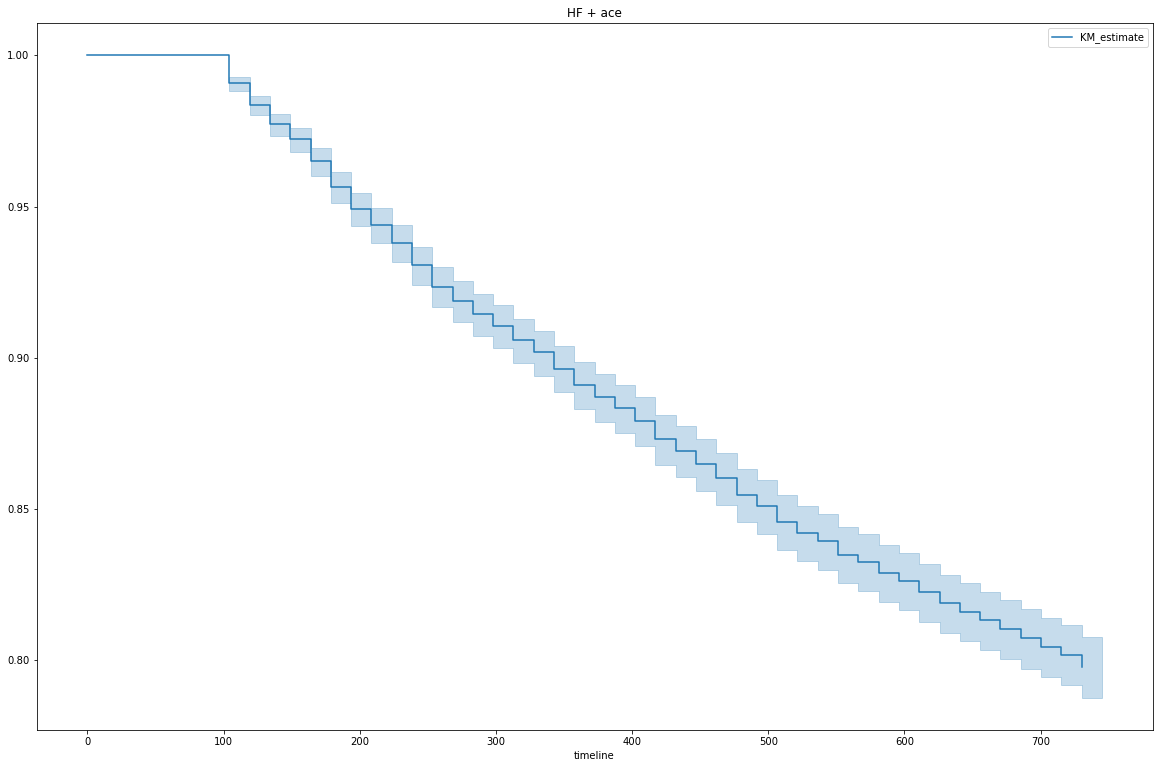

In [51]:
T2 = dataset_hf_ace['gap_find']
E2 = dataset_hf_ace['event']
t = np.linspace(0, 730)

kmf_hf_ace = KaplanMeierFitter()
kmf_hf_ace.fit(T2, event_observed=E2, timeline=t)
print("hf_ace:", kmf_hf_ace.median_)
kmf_hf_ace.plot(title='HF + ace')
plt.gcf().set_size_inches(20,13)

In [52]:
kmf_hf_ace.survival_function_ = kmf_hf_ace.survival_function_.reset_index()

In [53]:
type(kmf_hf_ace.survival_function_)

pandas.core.frame.DataFrame

In [54]:
kmf_hf_ace.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.992900,0.988096
119.183673,0.986574,0.980233
134.081633,0.980682,0.973227


In [55]:
kmf_hf_ace_180 = kmf_hf_ace.survival_function_.loc[kmf_hf_ace.survival_function_['timeline'] > 170]
kmf_hf_ace_180

,timeline,KM_estimate
12,178.775510,0.956445
13,193.673469,0.949185
14,208.571429,0.944023
15,223.469388,0.938055
16,238.367347,0.930634
17,253.265306,0.923536
18,268.163265,0.918858
19,283.061224,0.914502
20,297.959184,0.910631
21,312.857143,0.905791


### HF demographics

In [56]:
cols_1 = ['patid', 'gender', 'age_group']
hf_dem = pd.read_csv('HF only_demo_final.csv', names=cols_1, skiprows=1)
hf_dem.head()

,patid,gender,age_group
0,454,Female,6
1,929,Male,6
2,2280,Female,7
3,5233,Female,6
4,7551,Male,2


In [57]:
hf2 = hf.copy()

In [58]:
hf2 = hf2.reset_index()
hf2.head()

,date,patid,hf_event,hf_occur,beta_event,beta_occur,ace_event,ace_occur
0,2015-06-16,454,1,1.0,0,0.0,0,0.0
1,2015-09-10,454,1,1.0,0,0.0,0,0.0
2,2016-07-14,454,1,1.0,0,0.0,0,0.0
3,2017-03-16,454,1,1.0,0,0.0,0,0.0
4,2017-03-31,454,0,0.0,0,0.0,1,1.0


In [59]:
hf2_patid = hf2.groupby('patid')

In [60]:
results_12 = []

for patid, hf2 in hf2_patid:
    hf2 = hf2.sort_values('date')
    hf2['timeline'] = (hf2.iloc[-1, 0] - hf2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_12.append(pd.unique(hf2[['patid', 'timeline']].values.ravel('K')))  

In [61]:
data_12 = np.asarray(results_12)
hf2time = pd.DataFrame({'patid':data_12[:,0], 'timeline':data_12[:,1]})
hf2time.head()

,patid,timeline
0,454.0,801.0
1,929.0,1140.0
2,2280.0,1024.0
3,5233.0,732.0
4,7551.0,677.0


In [62]:
hf2time_2 = hf2time.loc[hf2time['timeline'] > 790]
hf2time_2.head()

,patid,timeline
0,454.0,801.0
1,929.0,1140.0
2,2280.0,1024.0
8,17085.0,1086.0
13,21241.0,1437.0


In [63]:
hf2time_2.describe()

,patid,timeline
count,1.131000e+04,11310.000000
mean,6.853956e+06,1362.209549
std,4.846430e+06,390.578617
min,4.540000e+02,791.000000
25%,2.716703e+06,1024.000000
50%,5.746557e+06,1300.000000
75%,1.048215e+07,1666.750000
max,1.738369e+07,2190.000000


In [64]:
hf2time_2.nunique()

patid       11310
timeline     1395
dtype: int64

In [65]:
hf_dem_new = pd.merge(hf_dem, hf2time_2, on=['patid'], how='inner')
hf_dem_new.head()

,patid,gender,age_group,timeline
0,454,Female,6,801.0
1,929,Male,6,1140.0
2,2280,Female,7,1024.0
3,17085,Male,6,1086.0
4,21241,Male,7,1437.0


In [66]:
hf_dem_new['gender'].value_counts()

Male      7384
Female    3926
Name: gender, dtype: int64

In [67]:
hf_dem_new['gender'].value_counts(normalize=True)

Male      0.652874
Female    0.347126
Name: gender, dtype: float64

In [68]:
hf_dem_new['age_group'].value_counts()

6    3473
5    3244
4    1956
7    1343
3     875
2     295
1      81
8      43
Name: age_group, dtype: int64

In [69]:
hf_dem_new['age_group'].value_counts(normalize=True)

6    0.307073
5    0.286826
4    0.172944
7    0.118744
3    0.077365
2    0.026083
1    0.007162
8    0.003802
Name: age_group, dtype: float64

### Creating HFaf tables

In [70]:
cols2 = ['patid', 'date', 'hf_event', 'hf_occur', 'af_event', 'af_occur', 'beta_event', 'beta_occur', 'anti_event', 'anti_occur', 'ace_event', 'ace_occur']
hfaf = pd.read_csv('HF_AF_copy.csv', parse_dates=['date'], index_col='date', names=cols2, skiprows=1)
hfaf.head() 

,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
date,,,,,,,,,,,
2014-07-01,929,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN
2014-10-30,929,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN
2016-01-30,929,0,NaN,1,1.0,0,NaN,0,NaN,0,NaN
2016-02-03,929,0,NaN,0,NaN,1,1.0,0,NaN,0,NaN
2016-03-02,929,0,NaN,0,NaN,1,1.0,0,NaN,0,NaN


In [71]:
hfaf = hfaf.fillna(0)

In [72]:
hfaf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364810 entries, 2014-07-01 to 2017-08-29
Data columns (total 11 columns):
patid         364810 non-null int64
hf_event      364810 non-null int64
hf_occur      364810 non-null float64
af_event      364810 non-null int64
af_occur      364810 non-null float64
beta_event    364810 non-null int64
beta_occur    364810 non-null float64
anti_event    364810 non-null int64
anti_occur    364810 non-null float64
ace_event     364810 non-null int64
ace_occur     364810 non-null float64
dtypes: float64(5), int64(6)
memory usage: 33.4 MB


In [73]:
hfaf['patid'].nunique()

5396

In [74]:
hfaf.head()

,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
date,,,,,,,,,,,
2014-07-01,929,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2014-10-30,929,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-01-30,929,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2016-02-03,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-03-02,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0


In [75]:
hfaf_beta = hfaf.loc[(hfaf['beta_event'] == 1) & (hfaf['beta_occur'] == 1.0)]
hfaf_beta.head()

,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
date,,,,,,,,,,,
2016-02-03,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-03-02,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-03-30,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-04-27,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-05-25,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0


In [76]:
hfaf_anti = hfaf.loc[(hfaf['anti_event'] == 1) & (hfaf['anti_occur'] == 1.0)]
hfaf_anti.head()

,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
date,,,,,,,,,,,
2016-07-13,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2016-08-10,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2016-09-07,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2016-10-03,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2016-10-31,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0


In [77]:
hfaf_ace = hfaf.loc[(hfaf['ace_event'] == 1) & (hfaf['ace_occur'] == 1.0)]
hfaf_ace.head()

,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
date,,,,,,,,,,,
2016-03-07,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2016-05-12,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2016-05-31,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2016-05-31,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2016-07-13,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0


In [78]:
hfaf_beta = hfaf_beta.reset_index()
hfaf_beta.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
0,2016-02-03,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
1,2016-03-02,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2,2016-03-30,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
3,2016-04-27,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
4,2016-05-25,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0


In [79]:
hfaf_anti = hfaf_anti.reset_index()
hfaf_anti.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
0,2016-07-13,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
1,2016-08-10,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2,2016-09-07,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
3,2016-10-03,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
4,2016-10-31,929,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0


In [80]:
hfaf_ace = hfaf_ace.reset_index()
hfaf_ace.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
0,2016-03-07,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
1,2016-05-12,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2,2016-05-31,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
3,2016-05-31,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
4,2016-07-13,929,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0


### HFaf_beta + HFaf_ace + HFaf_ace  find time

In [81]:
hfaf_beta2 = hfaf_beta.copy()

In [82]:
hfaf_anti2 = hfaf_anti.copy()

In [83]:
hfaf_ace2 = hfaf_ace.copy()

In [84]:
hfaf_beta_patid2 = hfaf_beta2.groupby('patid')

In [85]:
hfaf_anti_patid2 = hfaf_anti2.groupby('patid')

In [86]:
hfaf_ace_patid2 = hfaf_ace2.groupby('patid')

In [87]:
results_3 = []

for patid, hfaf_beta2 in hfaf_beta_patid2:
    hfaf_beta2 = hfaf_beta2.sort_values('date')
    hfaf_beta2['timeline'] = (hfaf_beta2.iloc[-1, 0] - hfaf_beta2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_3.append(pd.unique(hfaf_beta2[['patid', 'timeline']].values.ravel('K')))  

In [88]:
results_4 = []

for patid, hfaf_anti2 in hfaf_anti_patid2:
    hfaf_anti2 = hfaf_anti2.sort_values('date')
    hfaf_anti2['timeline'] = (hfaf_anti2.iloc[-1, 0] - hfaf_anti2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_4.append(pd.unique(hfaf_anti2[['patid', 'timeline']].values.ravel('K')))  

In [89]:
results_5 = []

for patid, hfaf_ace2 in hfaf_ace_patid2:
    hfaf_ace2 = hfaf_ace2.sort_values('date')
    hfaf_ace2['timeline'] = (hfaf_ace2.iloc[-1, 0] - hfaf_ace2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_5.append(pd.unique(hfaf_ace2[['patid', 'timeline']].values.ravel('K')))  

In [90]:
data_3 = np.asarray(results_3)
hfaf_beta_time = pd.DataFrame({'patid':data_3[:,0], 'timeline':data_3[:,1]})
hfaf_beta_time.head()

,patid,timeline
0,929.0,558.0
1,2280.0,155.0
2,12099.0,327.0
3,18346.0,66.0
4,19329.0,10.0


In [91]:
data_4 = np.asarray(results_4)
hfaf_anti_time = pd.DataFrame({'patid':data_4[:,0], 'timeline':data_4[:,1]})
hfaf_anti_time.head()

,patid,timeline
0,929.0,397.0
1,2280.0,182.0
2,12099.0,320.0
3,18346.0,157.0
4,19329.0,0.0


In [92]:
data_5 = np.asarray(results_5)
hfaf_ace_time = pd.DataFrame({'patid':data_5[:,0], 'timeline':data_5[:,1]})
hfaf_ace_time.head()

,patid,timeline
0,929.0,525.0
1,2280.0,182.0
2,12099.0,308.0
3,18346.0,91.0
4,19329.0,0.0


In [93]:
hfaf_beta_time.describe()

,patid,timeline
count,5.373000e+03,5373.000000
mean,7.115433e+06,548.075191
std,4.924437e+06,484.006787
min,9.290000e+02,0.000000
25%,2.866286e+06,155.000000
50%,5.997139e+06,410.000000
75%,1.104110e+07,825.000000
max,1.738308e+07,2148.000000


In [94]:
hfaf_anti_time.describe()

,patid,timeline
count,5.359000e+03,5359.000000
mean,7.119366e+06,524.239224
std,4.925172e+06,475.919155
min,9.290000e+02,0.000000
25%,2.867350e+06,140.000000
50%,6.004526e+06,384.000000
75%,1.103967e+07,791.000000
max,1.738308e+07,2148.000000


In [95]:
hfaf_ace_time.describe()

,patid,timeline
count,5.351000e+03,5351.000000
mean,7.124854e+06,484.688843
std,4.926349e+06,460.624832
min,9.290000e+02,0.000000
25%,2.870446e+06,114.000000
50%,6.005627e+06,337.000000
75%,1.105605e+07,733.000000
max,1.738308e+07,2144.000000


In [96]:
hfaf_beta_time_2 = hfaf_beta_time.loc[hfaf_beta_time['timeline'] > 790]
hfaf_beta_time_2.head()

,patid,timeline
12,46868.0,888.0
17,100569.0,940.0
18,101945.0,874.0
21,111342.0,987.0
26,150747.0,1056.0


In [97]:
hfaf_anti_time_2 = hfaf_anti_time.loc[hfaf_anti_time['timeline'] > 790]
hfaf_anti_time_2.head()

,patid,timeline
12,46868.0,910.0
17,100569.0,940.0
18,101945.0,854.0
21,111342.0,987.0
26,150747.0,1045.0


In [98]:
hfaf_ace_time_2 = hfaf_ace_time.loc[hfaf_ace_time['timeline'] > 790]
hfaf_ace_time_2.head()

,patid,timeline
12,46868.0,888.0
18,101945.0,874.0
21,111342.0,987.0
26,150747.0,952.0
27,151639.0,1156.0


In [99]:
hfaf_beta_time_2.nunique()

patid       1421
timeline     764
dtype: int64

In [100]:
hfaf_anti_time_2.nunique()

patid       1343
timeline     725
dtype: int64

In [101]:
hfaf_ace_time_2.nunique()

patid       1186
timeline     675
dtype: int64

In [102]:
hfaf_beta_time_2.describe()

,patid,timeline
count,1.421000e+03,1421.000000
mean,6.867308e+06,1226.665728
std,4.923468e+06,334.241475
min,4.686800e+04,791.000000
25%,2.601235e+06,949.000000
50%,5.634162e+06,1155.000000
75%,1.060486e+07,1428.000000
max,1.738308e+07,2148.000000


In [103]:
hfaf_anti_time_2.describe()

,patid,timeline
count,1.343000e+03,1343.000000
mean,6.819246e+06,1217.696947
std,4.915398e+06,324.189782
min,4.686800e+04,791.000000
25%,2.593975e+06,947.500000
50%,5.631051e+06,1153.000000
75%,1.052245e+07,1411.000000
max,1.738308e+07,2148.000000


In [104]:
hfaf_ace_time_2.describe()

,patid,timeline
count,1.186000e+03,1186.000000
mean,6.845269e+06,1208.707420
std,4.935061e+06,318.703144
min,4.686800e+04,791.000000
25%,2.599682e+06,937.500000
50%,5.639212e+06,1150.000000
75%,1.060204e+07,1404.250000
max,1.738308e+07,2144.000000


In [105]:
hfaf_beta_new = pd.merge(hfaf_beta, hfaf_beta_time_2, on=['patid'], how='inner')
hfaf_beta_new.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,timeline
0,2012-11-09,46868,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,888.0
1,2012-11-27,46868,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,888.0
2,2012-12-13,46868,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,888.0
3,2013-01-15,46868,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,888.0
4,2013-02-11,46868,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,888.0


In [106]:
hfaf_anti_new = pd.merge(hfaf_anti, hfaf_anti_time_2, on=['patid'], how='inner')
hfaf_anti_new.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,timeline
0,2012-10-18,46868,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,910.0
1,2012-11-09,46868,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,910.0
2,2012-11-09,46868,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,910.0
3,2012-12-13,46868,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,910.0
4,2012-12-13,46868,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,910.0


In [107]:
hfaf_ace_new = pd.merge(hfaf_ace, hfaf_ace_time_2, on=['patid'], how='inner')
hfaf_ace_new.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,timeline
0,2012-11-09,46868,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,888.0
1,2012-11-27,46868,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,888.0
2,2012-12-13,46868,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,888.0
3,2013-01-15,46868,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,888.0
4,2013-02-11,46868,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,888.0


In [108]:
type(hfaf_beta_new)

pandas.core.frame.DataFrame

In [109]:
type(hfaf_anti_new)

pandas.core.frame.DataFrame

In [110]:
type(hfaf_ace_new)

pandas.core.frame.DataFrame

In [111]:
hfaf_beta_new_patid = hfaf_beta_new.groupby('patid')

In [112]:
hfaf_anti_new_patid = hfaf_anti_new.groupby('patid')

In [113]:
hfaf_ace_new_patid = hfaf_ace_new.groupby('patid')

In [114]:
type(hfaf_beta_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [115]:
type(hfaf_ace_new_patid)

pandas.core.groupby.DataFrameGroupBy

### HFaf_beta + HFaf_anti +  HFaf_ace find gaps

In [116]:
results3 = []

for patid, hfaf_beta in hfaf_beta_new_patid:
    hfaf_beta = hfaf_beta.sort_values('date')
    hfaf_beta['gap'] = hfaf_beta.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfaf_beta.loc[hfaf_beta['gap'] > 90]
    
    if gap_find.empty == True:
        hfaf_beta['gap_find'] = 730 
        hfaf_beta['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfaf_beta['gap_find'] = (gap_find_date - hfaf_beta.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfaf_beta['event'] = 1
        
    results3.append(pd.unique(hfaf_beta[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [117]:
results4 = []

for patid, hfaf_anti in hfaf_anti_new_patid:
    hfaf_anti = hfaf_anti.sort_values('date')
    hfaf_anti['gap'] = hfaf_anti.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfaf_anti.loc[hfaf_anti['gap'] > 90]
    
    if gap_find.empty == True:
        hfaf_anti['gap_find'] = 730 
        hfaf_anti['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfaf_anti['gap_find'] = (gap_find_date - hfaf_anti.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfaf_anti['event'] = 1
        
    results4.append(pd.unique(hfaf_anti[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [118]:
results5 = []

for patid, hfaf_ace in hfaf_ace_new_patid:
    hfaf_ace = hfaf_ace.sort_values('date')
    hfaf_ace['gap'] = hfaf_ace.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfaf_ace.loc[hfaf_ace['gap'] > 90]
    
    if gap_find.empty == True:
        hfaf_ace['gap_find'] = 730 
        hfaf_ace['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfaf_ace['gap_find'] = (gap_find_date - hfaf_ace.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfaf_ace['event'] = 1
        
    results5.append(pd.unique(hfaf_ace[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [119]:
data3 = np.asarray(results3)
print(data3)

[[46868 730 0]
 [100569 693.0 1]
 [101945 167.0 1]
 ..., 
 [17373527 730 0]
 [17376703 730 0]
 [17383080 730 0]]


In [120]:
data4 = np.asarray(results4)
print(data4)

[[46868 730 0]
 [100569 730 0]
 [101945 168.0 1]
 ..., 
 [17373527 730 0]
 [17376703 730 0]
 [17383080 730 0]]


In [121]:
data5 = np.asarray(results5)
print(data5)

[[46868 730 0]
 [101945 167.0 1]
 [111342 197.0 1]
 ..., 
 [17342689 870.0 1]
 [17376703 730 0]
 [17383080 101.0 1]]


In [122]:
dataset_hfaf_beta = pd.DataFrame({'patid':data3[:,0],'gap_find':data3[:,1],'event':data3[:,2] })
dataset_hfaf_beta.head()

,event,gap_find,patid
0,0,730,46868
1,1,693,100569
2,1,167,101945
3,0,730,111342
4,1,1056,150747


In [123]:
dataset_hfaf_anti = pd.DataFrame({'patid':data4[:,0],'gap_find':data4[:,1],'event':data4[:,2] })
dataset_hfaf_anti.head()

,event,gap_find,patid
0,0,730,46868
1,0,730,100569
2,1,168,101945
3,1,229,111342
4,1,427,150747


In [124]:
dataset_hfaf_ace = pd.DataFrame({'patid':data5[:,0],'gap_find':data5[:,1],'event':data5[:,2] })
dataset_hfaf_ace.head()

,event,gap_find,patid
0,0,730,46868
1,1,167,101945
2,1,197,111342
3,0,730,150747
4,0,730,151639


In [125]:
dataset_hfaf_beta.patid.nunique()

1421

In [126]:
dataset_hfaf_anti.patid.nunique()

1343

In [127]:
dataset_hfaf_ace.patid.nunique()

1186

In [128]:
dataset_hfaf_beta.loc[dataset_hfaf_beta['gap_find'] < 0]

,event,gap_find,patid


In [129]:
dataset_hfaf_anti.loc[dataset_hfaf_anti['gap_find'] < 0]

,event,gap_find,patid


In [130]:
dataset_hfaf_ace.loc[dataset_hfaf_ace['gap_find'] < 0]

,event,gap_find,patid


hfaf_beta: inf


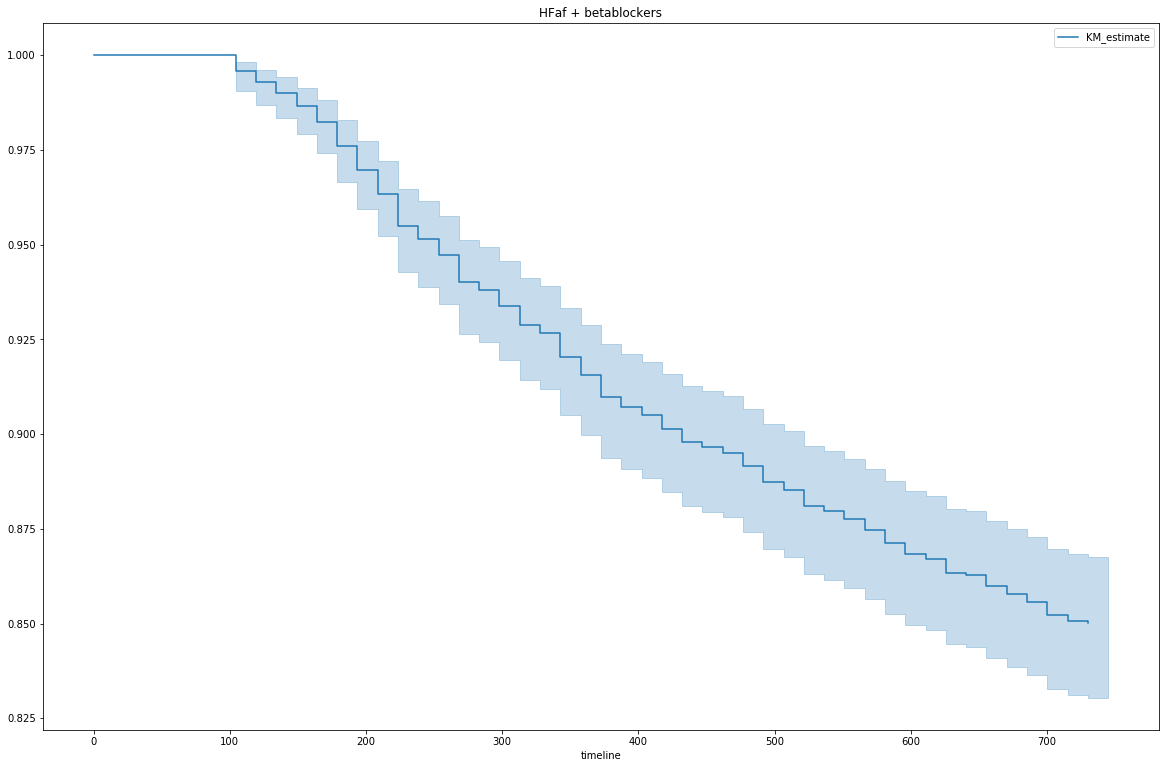

In [131]:
T3 = dataset_hfaf_beta['gap_find']
E3 = dataset_hfaf_beta['event']
t = np.linspace(0, 730)

kmf_hfaf_beta = KaplanMeierFitter()
kmf_hfaf_beta.fit(T3, event_observed=E3, timeline=t)
print("hfaf_beta:", kmf_hfaf_beta.median_)
kmf_hfaf_beta.plot(title='HFaf + betablockers')
plt.gcf().set_size_inches(20,13)

hfaf_anti: inf


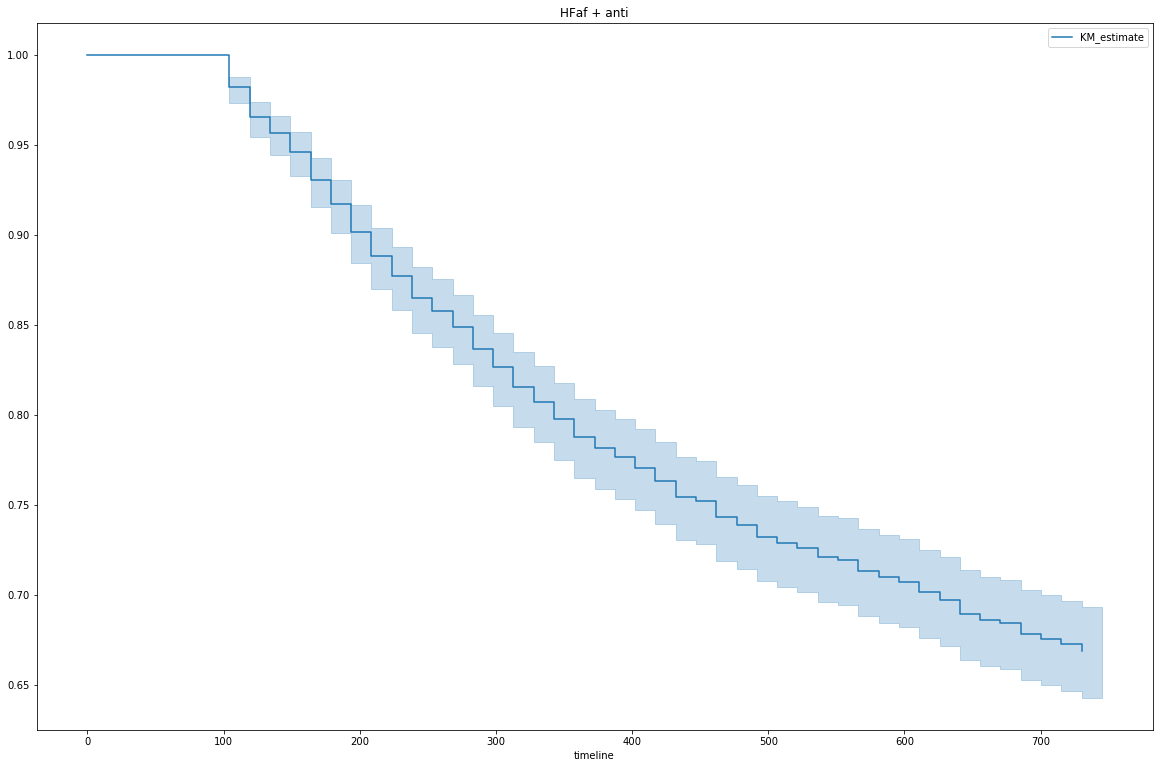

In [132]:
T4 = dataset_hfaf_anti['gap_find']
E4 = dataset_hfaf_anti['event']
t = np.linspace(0, 730)

kmf_hfaf_anti = KaplanMeierFitter()
kmf_hfaf_anti.fit(T4, event_observed=E4, timeline=t)
print("hfaf_anti:", kmf_hfaf_anti.median_)
kmf_hfaf_anti.plot(title='HFaf + anti')
plt.gcf().set_size_inches(20,13)

hfaf_ace: inf


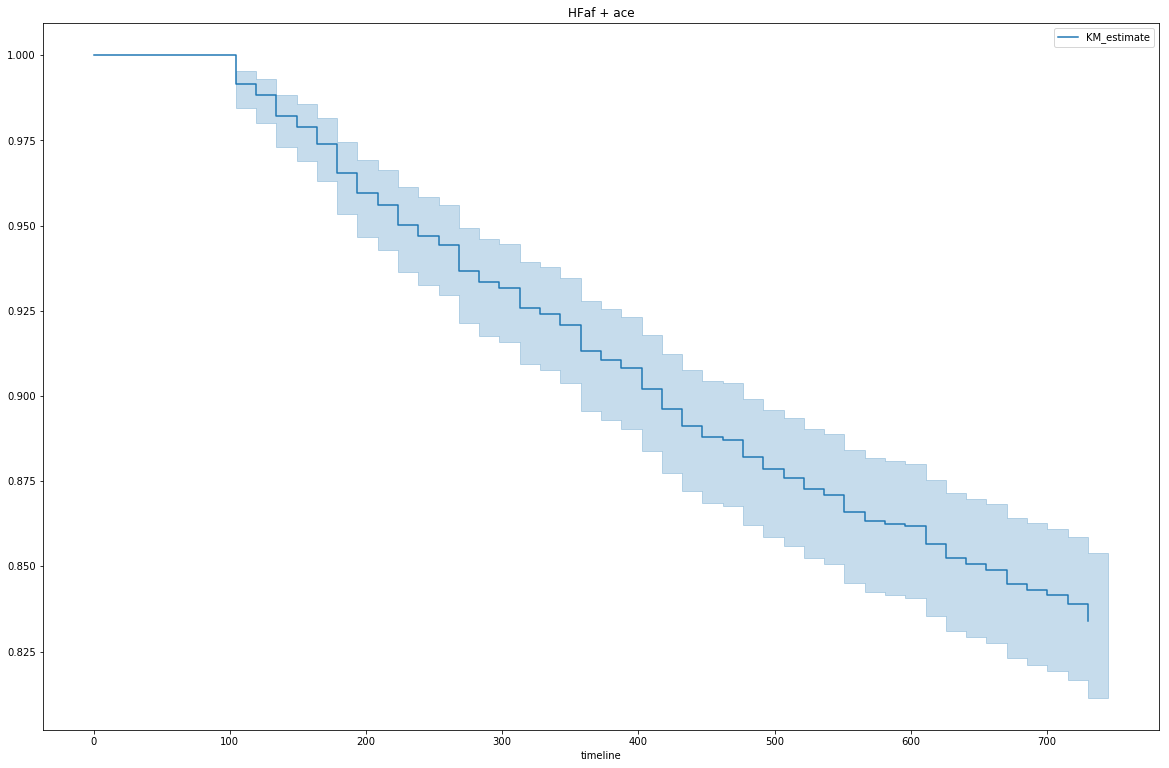

In [133]:
T5 = dataset_hfaf_ace['gap_find']
E5 = dataset_hfaf_ace['event']
t = np.linspace(0, 730)

kmf_hfaf_ace = KaplanMeierFitter()
kmf_hfaf_ace.fit(T5, event_observed=E5, timeline=t)
print("hfaf_ace:", kmf_hfaf_ace.median_)
kmf_hfaf_ace.plot(title='HFaf + ace')
plt.gcf().set_size_inches(20,13)

In [134]:
kmf_hfaf_beta.survival_function_ = kmf_hfaf_beta.survival_function_.reset_index()

In [135]:
kmf_hfaf_anti.survival_function_ = kmf_hfaf_anti.survival_function_.reset_index()

In [136]:
kmf_hfaf_ace.survival_function_ = kmf_hfaf_ace.survival_function_.reset_index()

In [137]:
type(kmf_hfaf_beta.survival_function_)

pandas.core.frame.DataFrame

In [138]:
type(kmf_hfaf_anti.survival_function_)

pandas.core.frame.DataFrame

In [139]:
type(kmf_hfaf_ace.survival_function_)

pandas.core.frame.DataFrame

In [140]:
kmf_hfaf_beta.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.998101,0.990626
119.183673,0.996207,0.986960
134.081633,0.994153,0.983421


In [141]:
kmf_hfaf_beta_180 = kmf_hfaf_beta.survival_function_.loc[kmf_hfaf_beta.survival_function_['timeline'] > 170]
kmf_hfaf_beta_180

,timeline,KM_estimate
12,178.775510,0.976073
13,193.673469,0.969740
14,208.571429,0.963406
15,223.469388,0.954961
16,238.367347,0.951443
17,253.265306,0.947220
18,268.163265,0.940183
19,283.061224,0.938072
20,297.959184,0.933849
21,312.857143,0.928923


In [142]:
kmf_hfaf_anti.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.987986,0.973456
119.183673,0.974233,0.954536
134.081633,0.966447,0.944494


In [143]:
kmf_hfaf_anti_180 = kmf_hfaf_anti.survival_function_.loc[kmf_hfaf_anti.survival_function_['timeline'] > 170]
kmf_hfaf_anti_180

,timeline,KM_estimate
12,178.775510,0.917349
13,193.673469,0.901713
14,208.571429,0.888310
15,223.469388,0.877141
16,238.367347,0.865227
17,253.265306,0.857781
18,268.163265,0.848846
19,283.061224,0.836932
20,297.959184,0.826508
21,312.857143,0.815339


In [144]:
kmf_hfaf_ace.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.995454,0.984386
119.183673,0.992992,0.980150
134.081633,0.988419,0.972972


In [145]:
kmf_hfaf_ace_180 = kmf_hfaf_ace.survival_function_.loc[kmf_hfaf_ace.survival_function_['timeline'] > 170]
kmf_hfaf_ace_180

,timeline,KM_estimate
12,178.775510,0.965430
13,193.673469,0.959528
14,208.571429,0.956155
15,223.469388,0.950253
16,238.367347,0.946880
17,253.265306,0.944351
18,268.163265,0.936762
19,283.061224,0.933390
20,297.959184,0.931703
21,312.857143,0.925801


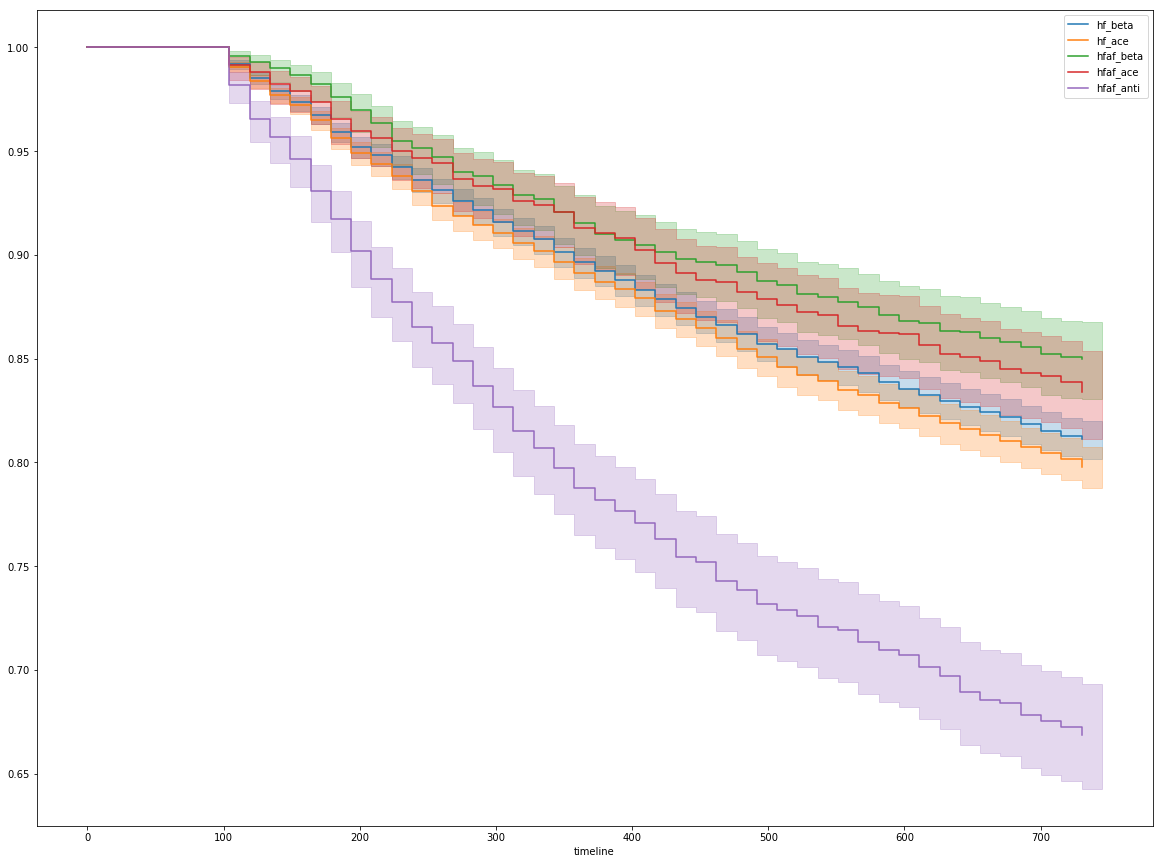

In [146]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(20,15))
ax = f.add_subplot(111)

kmf_hf_beta = KaplanMeierFitter()
ax = kmf_hf_beta.fit(T1, event_observed=E1, label='hf_beta', timeline=t).plot(ax=ax)

kmf_hf_ace = KaplanMeierFitter()
ax = kmf_hf_ace.fit(T2, event_observed=E2, label='hf_ace', timeline=t).plot(ax=ax)

kmf_hfaf_beta = KaplanMeierFitter()
ax = kmf_hfaf_beta.fit(T3, event_observed=E3, label='hfaf_beta', timeline=t).plot(ax=ax)

kmf_hfaf_ace = KaplanMeierFitter()
ax = kmf_hfaf_ace.fit(T5, event_observed=E5, label='hfaf_ace', timeline=t).plot(ax=ax)

kmf_hfaf_anti = KaplanMeierFitter()
ax = kmf_hfaf_anti.fit(T4, event_observed=E4, label='hfaf_anti', timeline=t).plot(ax=ax)

### HFaf demographics

In [147]:
cols_2 = ['patid', 'gender', 'age_group']
hfaf_dem = pd.read_csv('HF+AF_demo_final.csv', names=cols_2, skiprows=1)
hfaf_dem.head()

,patid,gender,age_group
0,929,Male,6
1,2280,Female,7
2,12099,Male,5
3,18346,Male,7
4,19329,Male,5


In [148]:
hfaf2 = hfaf.copy()

In [149]:
hfaf2 = hfaf2.reset_index()
hfaf2.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur
0,2014-07-01,929,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
1,2014-10-30,929,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2,2016-01-30,929,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
3,2016-02-03,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
4,2016-03-02,929,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0


In [150]:
hfaf2_patid = hfaf2.groupby('patid')

In [151]:
results_13 = []

for patid, hfaf2 in hfaf2_patid:
    hfaf2 = hfaf2.sort_values('date')
    hfaf2['timeline'] = (hfaf2.iloc[-1, 0] - hfaf2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_13.append(pd.unique(hfaf2[['patid', 'timeline']].values.ravel('K'))) 

In [152]:
data_13 = np.asarray(results_13)
hfaf2time = pd.DataFrame({'patid':data_13[:,0], 'timeline':data_13[:,1]})
hfaf2time.head()

,patid,timeline
0,929.0,1140.0
1,2280.0,1024.0
2,12099.0,915.0
3,18346.0,202.0
4,19329.0,480.0


In [153]:
hfaf2time_2 = hfaf2time.loc[hfaf2time['timeline'] > 790]
hfaf2time_2.head()

,patid,timeline
0,929.0,1140.0
1,2280.0,1024.0
2,12099.0,915.0
5,21241.0,1437.0
6,38312.0,1726.0


In [154]:
hfaf2time_2.describe()

,patid,timeline
count,3.445000e+03,3445.000000
mean,6.954706e+06,1413.101306
std,4.913697e+06,396.945320
min,9.290000e+02,791.000000
25%,2.768798e+06,1066.000000
50%,5.797616e+06,1374.000000
75%,1.077175e+07,1748.000000
max,1.738308e+07,2188.000000


In [155]:
hfaf_dem_new = pd.merge(hfaf_dem, hfaf2time_2, on=['patid'], how='inner')
hfaf_dem_new.head()

,patid,gender,age_group,timeline
0,929,Male,6,1140.0
1,2280,Female,7,1024.0
2,12099,Male,5,915.0
3,21241,Male,7,1437.0
4,38312,Male,5,1726.0


In [156]:
hfaf_dem_new['gender'].value_counts()

Male      2208
Female    1237
Name: gender, dtype: int64

In [157]:
hfaf_dem_new['gender'].value_counts(normalize=True)

Male      0.640929
Female    0.359071
Name: gender, dtype: float64

In [158]:
hfaf_dem_new['age_group'].value_counts()

6    1323
5    1051
4     458
7     406
3     175
2      26
1       5
8       1
Name: age_group, dtype: int64

In [159]:
hfaf_dem_new['age_group'].value_counts(normalize=True)

6    0.384035
5    0.305080
4    0.132946
7    0.117852
3    0.050798
2    0.007547
1    0.001451
8    0.000290
Name: age_group, dtype: float64

## HFafchd tables

In [160]:
cols3 = ['patid', 'date', 'hf_event', 'hf_occur', 'af_event', 'af_occur', 'chd_event', 'chd_occur', 'beta_event', 'beta_occur', 'anti_event', 'anti_occur', 'ace_event', 'ace_occur', 'plate_event', 'plate_occur', 'stat_event', 'stat_occur']
hfafchd = pd.read_csv('HF+AF+CHD copy.csv', parse_dates=['date'], index_col='date', names=cols3, skiprows=1)
hfafchd.head() 

,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,,,,,
2015-09-15,90788,0,NaN,0,NaN,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2015-09-15,90788,0,NaN,0,NaN,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2015-09-30,90788,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2015-09-30,90788,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2016-01-25,90788,0,NaN,0,NaN,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [161]:
hfafchd = hfafchd.fillna(0)

In [162]:
hfafchd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38464 entries, 2015-09-15 to 2014-03-14
Data columns (total 17 columns):
patid          38464 non-null int64
hf_event       38464 non-null int64
hf_occur       38464 non-null float64
af_event       38464 non-null int64
af_occur       38464 non-null float64
chd_event      38464 non-null int64
chd_occur      38464 non-null float64
beta_event     38464 non-null int64
beta_occur     38464 non-null float64
anti_event     38464 non-null int64
anti_occur     38464 non-null float64
ace_event      38464 non-null int64
ace_occur      38464 non-null float64
plate_event    38464 non-null int64
plate_occur    38464 non-null float64
stat_event     38464 non-null int64
stat_occur     38464 non-null float64
dtypes: float64(8), int64(9)
memory usage: 5.3 MB


In [163]:
hfafchd['patid'].nunique()

337

In [164]:
hfafchd.head()

,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,,,,,
2015-09-15,90788,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2015-09-15,90788,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2015-09-30,90788,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2015-09-30,90788,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-01-25,90788,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [165]:
hfafchd_beta = hfafchd.loc[(hfafchd['beta_event'] == 1) & (hfafchd['beta_occur'] == 1.0)]
hfafchd_beta.head()

,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,,,,,
2016-05-05,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-04-07,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-08-15,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-10-13,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-12-13,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0


In [166]:
hfafchd_anti = hfafchd.loc[(hfafchd['anti_event'] == 1) & (hfafchd['anti_occur'] == 1.0)]
hfafchd_anti.head()

,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,,,,,
2016-07-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2016-07-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2016-04-08,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2016-04-08,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2016-05-08,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0


In [167]:
hfafchd_ace = hfafchd.loc[(hfafchd['ace_event'] == 1) & (hfafchd['ace_occur'] == 1.0)]
hfafchd_ace.head()

,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,,,,,
2016-05-05,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-04-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-08-15,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-10-13,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2016-12-13,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0


In [168]:
hfafchd_plate = hfafchd.loc[(hfafchd['plate_event'] == 1) & (hfafchd['plate_occur'] == 1.0)]
hfafchd_plate.head()

,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,,,,,
2016-05-05,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2016-05-05,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2016-04-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2016-04-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2016-08-15,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0


In [169]:
hfafchd_stat = hfafchd.loc[(hfafchd['stat_event'] == 1) & (hfafchd['stat_occur'] == 1.0)]
hfafchd_stat.head()

,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,,,,,
2016-05-05,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2016-04-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2016-08-15,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2016-12-13,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2017-02-13,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0


In [170]:
hfafchd_beta = hfafchd_beta.reset_index()
hfafchd_beta.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2016-05-05,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
1,2016-04-07,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2,2016-08-15,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
3,2016-10-13,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
4,2016-12-13,90788,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0


In [171]:
hfafchd_anti = hfafchd_anti.reset_index()
hfafchd_anti.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2016-07-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
1,2016-07-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2,2016-04-08,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
3,2016-04-08,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
4,2016-05-08,90788,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0


In [172]:
hfafchd_ace = hfafchd_ace.reset_index()
hfafchd_ace.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2016-05-05,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
1,2016-04-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2,2016-08-15,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
3,2016-10-13,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
4,2016-12-13,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0


In [173]:
hfafchd_plate = hfafchd_plate.reset_index()
hfafchd_plate.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2016-05-05,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
1,2016-05-05,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2,2016-04-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
3,2016-04-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
4,2016-08-15,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0


In [174]:
hfafchd_stat = hfafchd_stat.reset_index()
hfafchd_stat.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2016-05-05,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
1,2016-04-07,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2,2016-08-15,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
3,2016-12-13,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
4,2017-02-13,90788,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0


### HFafchd find time

In [175]:
hfafchd_beta2 = hfafchd_beta.copy()

In [176]:
hfafchd_anti2 = hfafchd_anti.copy()

In [177]:
hfafchd_ace2 = hfafchd_ace.copy()

In [178]:
hfafchd_plate2 = hfafchd_plate.copy()

In [179]:
hfafchd_stat2 = hfafchd_stat.copy()

In [180]:
hfafchd_beta_patid2 = hfafchd_beta2.groupby('patid')

In [181]:
hfafchd_anti_patid2 = hfafchd_anti2.groupby('patid')

In [182]:
hfafchd_ace_patid2 = hfafchd_ace2.groupby('patid')

In [183]:
hfafchd_plate_patid2 = hfafchd_plate2.groupby('patid')

In [184]:
hfafchd_stat_patid2 = hfafchd_stat2.groupby('patid')

In [185]:
results_6 = []

for patid, hfafchd_beta2 in hfafchd_beta_patid2:
    hfafchd_beta2 = hfafchd_beta2.sort_values('date')
    hfafchd_beta2['timeline'] = (hfafchd_beta2.iloc[-1, 0] - hfafchd_beta2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_6.append(pd.unique(hfafchd_beta2[['patid', 'timeline']].values.ravel('K')))  

In [186]:
results_7 = []

for patid, hfafchd_anti2 in hfafchd_anti_patid2:
    hfafchd_anti2 = hfafchd_anti2.sort_values('date')
    hfafchd_anti2['timeline'] = (hfafchd_anti2.iloc[-1, 0] - hfafchd_anti2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_7.append(pd.unique(hfafchd_anti2[['patid', 'timeline']].values.ravel('K')))  

In [187]:
results_8 = []

for patid, hfafchd_ace2 in hfafchd_ace_patid2:
    hfafchd_ace2 = hfafchd_ace2.sort_values('date')
    hfafchd_ace2['timeline'] = (hfafchd_ace2.iloc[-1, 0] - hfafchd_ace2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_8.append(pd.unique(hfafchd_ace2[['patid', 'timeline']].values.ravel('K')))  

In [188]:
results_9 = []

for patid, hfafchd_plate2 in hfafchd_plate_patid2:
    hfafchd_plate2 = hfafchd_plate2.sort_values('date')
    hfafchd_plate2['timeline'] = (hfafchd_plate2.iloc[-1, 0] - hfafchd_plate2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_9.append(pd.unique(hfafchd_plate2[['patid', 'timeline']].values.ravel('K')))  

In [189]:
results_10 = []

for patid, hfafchd_stat2 in hfafchd_stat_patid2:
    hfafchd_stat2 = hfafchd_stat2.sort_values('date')
    hfafchd_stat2['timeline'] = (hfafchd_stat2.iloc[-1, 0] - hfafchd_stat2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_10.append(pd.unique(hfafchd_stat2[['patid', 'timeline']].values.ravel('K')))  

In [190]:
data_6 = np.asarray(results_6)
hfafchd_beta_time = pd.DataFrame({'patid':data_6[:,0], 'timeline':data_6[:,1]})
hfafchd_beta_time.head()

,patid,timeline
0,90788.0,606.0
1,101945.0,997.0
2,102649.0,0.0
3,137408.0,85.0
4,288593.0,475.0


In [191]:
data_7 = np.asarray(results_7)
hfafchd_anti_time = pd.DataFrame({'patid':data_7[:,0], 'timeline':data_7[:,1]})
hfafchd_anti_time.head()

,patid,timeline
0,90788.0,605.0
1,101945.0,1004.0
2,102649.0,0.0
3,137408.0,3.0
4,288593.0,475.0


In [192]:
data_8 = np.asarray(results_8)
hfafchd_ace_time = pd.DataFrame({'patid':data_8[:,0], 'timeline':data_8[:,1]})
hfafchd_ace_time.head()

,patid,timeline
0,90788.0,606.0
1,101945.0,997.0
2,102649.0,62.0
3,137408.0,85.0
4,288593.0,475.0


In [193]:
data_9 = np.asarray(results_9)
hfafchd_plate_time = pd.DataFrame({'patid':data_9[:,0], 'timeline':data_9[:,1]})
hfafchd_plate_time.head()

,patid,timeline
0,90788.0,606.0
1,101945.0,997.0
2,102649.0,90.0
3,137408.0,85.0
4,288593.0,475.0


In [194]:
data_10 = np.asarray(results_10)
hfafchd_stat_time = pd.DataFrame({'patid':data_10[:,0], 'timeline':data_10[:,1]})
hfafchd_stat_time.head()

,patid,timeline
0,90788.0,433.0
1,101945.0,997.0
2,102649.0,90.0
3,137408.0,85.0
4,288593.0,475.0


In [195]:
hfafchd_beta_time.describe()

,patid,timeline
count,3.360000e+02,336.000000
mean,7.118373e+06,740.339286
std,4.974539e+06,487.608937
min,9.078800e+04,0.000000
25%,3.007393e+06,357.000000
50%,6.119628e+06,659.000000
75%,1.095703e+07,1037.000000
max,1.737411e+07,2139.000000


In [196]:
hfafchd_anti_time.describe()

,patid,timeline
count,3.350000e+02,335.000000
mean,7.102568e+06,655.880597
std,4.953803e+06,496.402837
min,9.078800e+04,0.000000
25%,3.042576e+06,252.000000
50%,6.047720e+06,577.000000
75%,1.081215e+07,998.500000
max,1.737411e+07,2139.000000


In [197]:
hfafchd_ace_time.describe()

,patid,timeline
count,3.350000e+02,335.000000
mean,7.096455e+06,667.376119
std,4.965704e+06,478.648805
min,9.078800e+04,0.000000
25%,3.002970e+06,285.000000
50%,6.047720e+06,606.000000
75%,1.081215e+07,953.500000
max,1.737411e+07,2139.000000


In [198]:
hfafchd_plate_time.describe()

,patid,timeline
count,3.360000e+02,336.000000
mean,7.118373e+06,504.675595
std,4.974539e+06,431.857210
min,9.078800e+04,0.000000
25%,3.007393e+06,172.750000
50%,6.119628e+06,377.500000
75%,1.095703e+07,718.500000
max,1.737411e+07,2139.000000


In [199]:
hfafchd_stat_time.describe()

,patid,timeline
count,3.360000e+02,336.000000
mean,7.118373e+06,736.083333
std,4.974539e+06,485.186752
min,9.078800e+04,0.000000
25%,3.007393e+06,362.250000
50%,6.119628e+06,654.000000
75%,1.095703e+07,1036.000000
max,1.737411e+07,2184.000000


In [200]:
hfafchd_beta_time_2 = hfafchd_beta_time.loc[hfafchd_beta_time['timeline'] > 790]
hfafchd_beta_time_2.head()

,patid,timeline
1,101945.0,997.0
6,403424.0,1026.0
8,469315.0,968.0
10,563427.0,1073.0
11,601263.0,796.0


In [201]:
hfafchd_anti_time_2 = hfafchd_anti_time.loc[hfafchd_anti_time['timeline'] > 790]
hfafchd_anti_time_2.head()

,patid,timeline
1,101945.0,1004.0
6,403424.0,1026.0
10,563427.0,992.0
14,767237.0,1675.0
15,840620.0,1347.0


In [202]:
hfafchd_ace_time_2 = hfafchd_ace_time.loc[hfafchd_ace_time['timeline'] > 790]
hfafchd_ace_time_2.head()

,patid,timeline
1,101945.0,997.0
8,469315.0,968.0
10,563427.0,1269.0
13,750976.0,1062.0
14,767237.0,1820.0


In [203]:
hfafchd_plate_time_2 = hfafchd_plate_time.loc[hfafchd_plate_time['timeline'] > 790]
hfafchd_plate_time_2.head()

,patid,timeline
1,101945.0,997.0
8,469315.0,968.0
10,563427.0,1073.0
14,767237.0,1025.0
19,932688.0,953.0


In [204]:
hfafchd_stat_time_2 = hfafchd_stat_time.loc[hfafchd_stat_time['timeline'] > 790]
hfafchd_stat_time_2.head()

,patid,timeline
1,101945.0,997.0
6,403424.0,931.0
8,469315.0,964.0
10,563427.0,1073.0
13,750976.0,1062.0


In [205]:
hfafchd_beta_time_2.nunique()

patid       139
timeline    128
dtype: int64

In [206]:
hfafchd_anti_time_2.nunique()

patid       117
timeline    112
dtype: int64

In [207]:
hfafchd_ace_time_2.nunique()

patid       116
timeline    110
dtype: int64

In [208]:
hfafchd_plate_time_2.nunique()

patid       75
timeline    68
dtype: int64

In [209]:
hfafchd_stat_time_2.nunique()

patid       136
timeline    123
dtype: int64

In [210]:
hfafchd_beta_time_2.describe()

,patid,timeline
count,1.390000e+02,139.000000
mean,6.864964e+06,1218.438849
std,5.064950e+06,325.443735
min,1.019450e+05,796.000000
25%,2.746412e+06,954.500000
50%,5.269267e+06,1129.000000
75%,1.027175e+07,1398.500000
max,1.724595e+07,2139.000000


In [211]:
hfafchd_anti_time_2.describe()

,patid,timeline
count,1.170000e+02,117.000000
mean,6.775601e+06,1224.743590
std,4.751086e+06,314.733745
min,1.019450e+05,803.000000
25%,2.828969e+06,992.000000
50%,5.797616e+06,1194.000000
75%,1.013340e+07,1419.000000
max,1.724595e+07,2139.000000


In [212]:
hfafchd_ace_time_2.describe()

,patid,timeline
count,1.160000e+02,116.000000
mean,6.776783e+06,1206.422414
std,4.966796e+06,329.817661
min,1.019450e+05,810.000000
25%,2.730249e+06,948.750000
50%,5.562064e+06,1083.500000
75%,1.039075e+07,1389.000000
max,1.724595e+07,2139.000000


In [213]:
hfafchd_plate_time_2.describe()

,patid,timeline
count,7.500000e+01,75.000000
mean,6.818132e+06,1168.280000
std,4.932061e+06,296.962304
min,1.019450e+05,792.000000
25%,2.727888e+06,943.500000
50%,6.261073e+06,1072.000000
75%,9.415649e+06,1374.000000
max,1.724595e+07,2139.000000


In [214]:
hfafchd_stat_time_2.describe()

,patid,timeline
count,1.360000e+02,136.000000
mean,6.904108e+06,1221.808824
std,4.963679e+06,326.594766
min,1.019450e+05,792.000000
25%,2.890382e+06,974.750000
50%,5.994576e+06,1129.500000
75%,1.039075e+07,1378.750000
max,1.724595e+07,2184.000000


In [215]:
hfafchd_beta_new = pd.merge(hfafchd_beta, hfafchd_beta_time_2, on=['patid'], how='inner')
hfafchd_beta_new.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2014-04-23,101945,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,997.0
1,2014-05-15,101945,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,997.0
2,2014-06-25,101945,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,997.0
3,2014-08-07,101945,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,997.0
4,2014-07-10,101945,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,997.0


In [216]:
hfafchd_anti_new = pd.merge(hfafchd_anti, hfafchd_anti_time_2, on=['patid'], how='inner')
hfafchd_anti_new.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2014-04-22,101945,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1004.0
1,2014-04-22,101945,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1004.0
2,2014-02-05,101945,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1004.0
3,2014-02-05,101945,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1004.0
4,2014-05-15,101945,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1004.0


In [217]:
hfafchd_ace_new = pd.merge(hfafchd_ace, hfafchd_ace_time_2, on=['patid'], how='inner')
hfafchd_ace_new.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2014-04-23,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,997.0
1,2014-05-15,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,997.0
2,2014-06-25,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,997.0
3,2014-08-07,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,997.0
4,2014-07-10,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,997.0


In [218]:
hfafchd_plate_new = pd.merge(hfafchd_plate, hfafchd_plate_time_2, on=['patid'], how='inner')
hfafchd_plate_new.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2014-04-23,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,997.0
1,2014-05-15,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,997.0
2,2014-06-25,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,997.0
3,2014-08-07,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,997.0
4,2014-07-10,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,997.0


In [219]:
hfafchd_stat_new = pd.merge(hfafchd_stat, hfafchd_stat_time_2, on=['patid'], how='inner')
hfafchd_stat_new.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2014-04-23,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,997.0
1,2014-05-15,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,997.0
2,2014-06-25,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,997.0
3,2014-08-07,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,997.0
4,2014-07-10,101945,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,997.0


In [220]:
type(hfafchd_beta_new)

pandas.core.frame.DataFrame

In [221]:
type(hfafchd_anti_new)

pandas.core.frame.DataFrame

In [222]:
type(hfafchd_ace_new)

pandas.core.frame.DataFrame

In [223]:
type(hfafchd_plate_new)

pandas.core.frame.DataFrame

In [224]:
type(hfafchd_stat_new)

pandas.core.frame.DataFrame

In [225]:
hfafchd_beta_new_patid = hfafchd_beta_new.groupby('patid')

In [226]:
hfafchd_anti_new_patid = hfafchd_anti_new.groupby('patid')

In [227]:
hfafchd_ace_new_patid = hfafchd_ace_new.groupby('patid')

In [228]:
hfafchd_plate_new_patid = hfafchd_plate_new.groupby('patid')

In [229]:
hfafchd_stat_new_patid = hfafchd_stat_new.groupby('patid')

In [230]:
type(hfafchd_beta_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [231]:
type(hfafchd_anti_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [232]:
type(hfafchd_ace_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [233]:
type(hfafchd_plate_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [234]:
type(hfafchd_stat_new_patid)

pandas.core.groupby.DataFrameGroupBy

### HFafchd find gaps

In [235]:
results6 = []

for patid, hfafchd_beta in hfafchd_beta_new_patid:
    hfafchd_beta = hfafchd_beta.sort_values('date')
    hfafchd_beta['gap'] = hfafchd_beta.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfafchd_beta.loc[hfafchd_beta['gap'] > 90]
    
    if gap_find.empty == True:
        hfafchd_beta['gap_find'] = 730 
        hfafchd_beta['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfafchd_beta['gap_find'] = (gap_find_date - hfafchd_beta.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfafchd_beta['event'] = 1
        
    results6.append(pd.unique(hfafchd_beta[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [236]:
results7 = []

for patid, hfafchd_anti in hfafchd_anti_new_patid:
    hfafchd_anti = hfafchd_anti.sort_values('date')
    hfafchd_anti['gap'] = hfafchd_anti.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfafchd_anti.loc[hfafchd_anti['gap'] > 90]
    
    if gap_find.empty == True:
        hfafchd_anti['gap_find'] = 730 
        hfafchd_anti['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfafchd_anti['gap_find'] = (gap_find_date - hfafchd_anti.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfafchd_anti['event'] = 1
        
    results7.append(pd.unique(hfafchd_anti[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [237]:
results8 = []

for patid, hfafchd_ace in hfafchd_ace_new_patid:
    hfafchd_ace = hfafchd_ace.sort_values('date')
    hfafchd_ace['gap'] = hfafchd_ace.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfafchd_ace.loc[hfafchd_ace['gap'] > 90]
    
    if gap_find.empty == True:
        hfafchd_ace['gap_find'] = 730 
        hfafchd_ace['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfafchd_ace['gap_find'] = (gap_find_date - hfafchd_ace.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfafchd_ace['event'] = 1
        
    results8.append(pd.unique(hfafchd_ace[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [238]:
results9 = []

for patid, hfafchd_plate in hfafchd_plate_new_patid:
    hfafchd_plate = hfafchd_plate.sort_values('date')
    hfafchd_plate['gap'] = hfafchd_plate.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfafchd_plate.loc[hfafchd_plate['gap'] > 90]
    
    if gap_find.empty == True:
        hfafchd_plate['gap_find'] = 730 
        hfafchd_plate['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfafchd_plate['gap_find'] = (gap_find_date - hfafchd_plate.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfafchd_plate['event'] = 1
        
    results9.append(pd.unique(hfafchd_plate[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [239]:
results10 = []

for patid, hfafchd_stat in hfafchd_stat_new_patid:
    hfafchd_stat = hfafchd_stat.sort_values('date')
    hfafchd_stat['gap'] = hfafchd_stat.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfafchd_stat.loc[hfafchd_stat['gap'] > 90]
    
    if gap_find.empty == True:
        hfafchd_stat['gap_find'] = 730 
        hfafchd_stat['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfafchd_stat['gap_find'] = (gap_find_date - hfafchd_stat.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfafchd_stat['event'] = 1
        
    results10.append(pd.unique(hfafchd_stat[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [240]:
data6 = np.asarray(results6)
print(data6)

[[101945 349.0 1]
 [403424 247.0 1]
 [469315 214.0 1]
 [563427 558.0 1]
 [601263 210.0 1]
 [750976 1062.0 1]
 [767237 98.0 1]
 [840620 384.0 1]
 [932688 142.0 1]
 [941337 136.0 1]
 [942017 1042.0 1]
 [961003 169.0 1]
 [965083 263.0 1]
 [988341 730 0]
 [1046355 353.0 1]
 [1183620 290.0 1]
 [1294369 343.0 1]
 [1312991 148.0 1]
 [1348424 228.0 1]
 [1384503 200.0 1]
 [1394369 169.0 1]
 [1488697 150.0 1]
 [1518296 115.0 1]
 [1655855 295.0 1]
 [1675717 148.0 1]
 [1699935 421.0 1]
 [1848074 730 0]
 [1851537 730 0]
 [1946862 1045.0 1]
 [2138598 101.0 1]
 [2231614 103.0 1]
 [2305722 1030.0 1]
 [2356859 518.0 1]
 [2723167 478.0 1]
 [2732610 426.0 1]
 [2760213 647.0 1]
 [2828969 198.0 1]
 [2910853 730 0]
 [2933307 148.0 1]
 [2994123 636.0 1]
 [3011816 212.0 1]
 [3073335 103.0 1]
 [3074675 730 0]
 [3133192 248.0 1]
 [3159883 222.0 1]
 [3209679 292.0 1]
 [3421255 261.0 1]
 [3553457 142.0 1]
 [3575164 284.0 1]
 [3673545 143.0 1]
 [3707999 131.0 1]
 [3716136 513.0 1]
 [3777708 158.0 1]
 [3888264 730 

In [241]:
data7 = np.asarray(results7)
print(data7)

[[101945 356.0 1]
 [403424 247.0 1]
 [563427 307.0 1]
 [767237 99.0 1]
 [840620 143.0 1]
 [932688 142.0 1]
 [941337 136.0 1]
 [961003 176.0 1]
 [965083 296.0 1]
 [988341 232.0 1]
 [1002732 278.0 1]
 [1046355 319.0 1]
 [1294369 1152.0 1]
 [1348424 167.0 1]
 [1384503 200.0 1]
 [1394369 169.0 1]
 [1488697 150.0 1]
 [1518296 115.0 1]
 [1655855 406.0 1]
 [1675717 138.0 1]
 [1699935 127.0 1]
 [1848074 190.0 1]
 [1851537 899.0 1]
 [2138598 177.0 1]
 [2231614 260.0 1]
 [2305722 291.0 1]
 [2356859 211.0 1]
 [2411823 223.0 1]
 [2732610 730 0]
 [2828969 182.0 1]
 [2910853 730 0]
 [2994123 693.0 1]
 [3011816 146.0 1]
 [3073335 961.0 1]
 [3074675 245.0 1]
 [3133192 181.0 1]
 [3209679 292.0 1]
 [3553457 154.0 1]
 [3575164 190.0 1]
 [3673545 143.0 1]
 [3707999 127.0 1]
 [3716136 730 0]
 [3888264 955.0 1]
 [4120570 262.0 1]
 [4127642 260.0 1]
 [4137384 581.0 1]
 [4167777 896.0 1]
 [4234573 319.0 1]
 [4249896 730 0]
 [4266477 338.0 1]
 [4277385 1001.0 1]
 [4477093 201.0 1]
 [4679292 1058.0 1]
 [4732074

In [242]:
data8 = np.asarray(results8)
print(data8)

[[101945 349.0 1]
 [469315 214.0 1]
 [563427 224.0 1]
 [750976 1062.0 1]
 [767237 98.0 1]
 [840620 153.0 1]
 [932688 142.0 1]
 [941337 136.0 1]
 [942017 270.0 1]
 [961003 176.0 1]
 [965083 742.0 1]
 [988341 730 0]
 [1046355 353.0 1]
 [1294369 635.0 1]
 [1312991 379.0 1]
 [1348424 167.0 1]
 [1384503 200.0 1]
 [1394369 249.0 1]
 [1488697 150.0 1]
 [1518296 115.0 1]
 [1655855 442.0 1]
 [1675717 148.0 1]
 [1699935 377.0 1]
 [1848074 730 0]
 [1946862 1045.0 1]
 [2231614 535.0 1]
 [2305722 968.0 1]
 [2356859 370.0 1]
 [2723167 478.0 1]
 [2732610 726.0 1]
 [2760213 647.0 1]
 [2910853 291.0 1]
 [2933307 148.0 1]
 [2994123 693.0 1]
 [3011816 730 0]
 [3073335 130.0 1]
 [3074675 730 0]
 [3133192 248.0 1]
 [3159883 222.0 1]
 [3209679 679.0 1]
 [3252749 730 0]
 [3421255 261.0 1]
 [3553457 142.0 1]
 [3579321 250.0 1]
 [3707999 127.0 1]
 [3716136 108.0 1]
 [3777708 150.0 1]
 [4120570 297.0 1]
 [4127642 172.0 1]
 [4167777 896.0 1]
 [4234573 240.0 1]
 [4266477 1251.0 1]
 [4277385 730 0]
 [4679292 91.0 

In [243]:
data9 = np.asarray(results9)
print(data9)

[[101945 349.0 1]
 [469315 214.0 1]
 [563427 558.0 1]
 [767237 125.0 1]
 [932688 142.0 1]
 [941337 333.0 1]
 [1046355 376.0 1]
 [1312991 317.0 1]
 [1384503 200.0 1]
 [1394369 319.0 1]
 [1488697 150.0 1]
 [1518296 591.0 1]
 [1675717 148.0 1]
 [1699935 432.0 1]
 [1848074 245.0 1]
 [1851537 511.0 1]
 [1946862 441.0 1]
 [2231614 502.0 1]
 [2723167 331.0 1]
 [2732610 426.0 1]
 [2994123 636.0 1]
 [3159883 222.0 1]
 [3209679 292.0 1]
 [3252749 730 0]
 [3421255 262.0 1]
 [3553457 135.0 1]
 [4127642 172.0 1]
 [4167777 896.0 1]
 [4249896 730 0]
 [4266477 116.0 1]
 [4277385 730 0]
 [4477093 215.0 1]
 [4679292 1586.0 1]
 [4982879 138.0 1]
 [5065925 903.0 1]
 [5269267 730 0]
 [5797616 125.0 1]
 [6261073 746.0 1]
 [6362301 210.0 1]
 [6459670 730 0]
 [6638100 217.0 1]
 [6916808 989.0 1]
 [7153965 95.0 1]
 [7413845 312.0 1]
 [7494663 815.0 1]
 [7664499 181.0 1]
 [7977257 410.0 1]
 [8164256 554.0 1]
 [8385710 323.0 1]
 [8405275 382.0 1]
 [8557712 138.0 1]
 [8568975 284.0 1]
 [8611174 294.0 1]
 [8754232

In [244]:
data10 = np.asarray(results10)
print(data10)

[[101945 349.0 1]
 [403424 247.0 1]
 [469315 214.0 1]
 [563427 558.0 1]
 [750976 1062.0 1]
 [767237 580.0 1]
 [840620 218.0 1]
 [932688 142.0 1]
 [941337 333.0 1]
 [942017 1059.0 1]
 [961003 156.0 1]
 [965083 189.0 1]
 [988341 730 0]
 [1046355 319.0 1]
 [1294369 1152.0 1]
 [1312991 125.0 1]
 [1348424 229.0 1]
 [1384503 200.0 1]
 [1394369 196.0 1]
 [1488697 1026.0 1]
 [1518296 115.0 1]
 [1655855 442.0 1]
 [1675717 148.0 1]
 [1699935 378.0 1]
 [1848074 730 0]
 [1851537 511.0 1]
 [1946862 1045.0 1]
 [2138598 309.0 1]
 [2231614 103.0 1]
 [2305722 1030.0 1]
 [2411823 226.0 1]
 [2723167 478.0 1]
 [2760213 647.0 1]
 [2828969 237.0 1]
 [2910853 291.0 1]
 [2933307 320.0 1]
 [2994123 636.0 1]
 [3011816 146.0 1]
 [3073335 118.0 1]
 [3074675 730 0]
 [3133192 248.0 1]
 [3159883 222.0 1]
 [3209679 292.0 1]
 [3421255 261.0 1]
 [3488680 121.0 1]
 [3553457 199.0 1]
 [3575164 254.0 1]
 [3673545 143.0 1]
 [3707999 127.0 1]
 [3716136 134.0 1]
 [3888264 730 0]
 [4120570 280.0 1]
 [4127642 172.0 1]
 [413738

In [245]:
dataset_hfafchd_beta = pd.DataFrame({'patid':data6[:,0],'gap_find':data6[:,1],'event':data6[:,2] })
dataset_hfafchd_beta.head()

,event,gap_find,patid
0,1,349,101945
1,1,247,403424
2,1,214,469315
3,1,558,563427
4,1,210,601263


In [246]:
dataset_hfafchd_anti = pd.DataFrame({'patid':data7[:,0],'gap_find':data7[:,1],'event':data7[:,2] })
dataset_hfafchd_anti.head()

,event,gap_find,patid
0,1,356,101945
1,1,247,403424
2,1,307,563427
3,1,99,767237
4,1,143,840620


In [247]:
dataset_hfafchd_ace = pd.DataFrame({'patid':data8[:,0],'gap_find':data8[:,1],'event':data8[:,2] })
dataset_hfafchd_ace.head()

,event,gap_find,patid
0,1,349,101945
1,1,214,469315
2,1,224,563427
3,1,1062,750976
4,1,98,767237


In [248]:
dataset_hfafchd_plate = pd.DataFrame({'patid':data9[:,0],'gap_find':data9[:,1],'event':data9[:,2] })
dataset_hfafchd_plate.head()

,event,gap_find,patid
0,1,349,101945
1,1,214,469315
2,1,558,563427
3,1,125,767237
4,1,142,932688


In [249]:
dataset_hfafchd_stat = pd.DataFrame({'patid':data10[:,0],'gap_find':data10[:,1],'event':data10[:,2] })
dataset_hfafchd_stat.head()

,event,gap_find,patid
0,1,349,101945
1,1,247,403424
2,1,214,469315
3,1,558,563427
4,1,1062,750976


In [250]:
dataset_hfafchd_beta.patid.nunique()

139

In [251]:
dataset_hfafchd_anti.patid.nunique()

117

In [252]:
dataset_hfafchd_ace.patid.nunique()

116

In [253]:
dataset_hfafchd_plate.patid.nunique()

75

In [254]:
dataset_hfafchd_stat.patid.nunique()

136

hfafchd_beta: 297.959183673


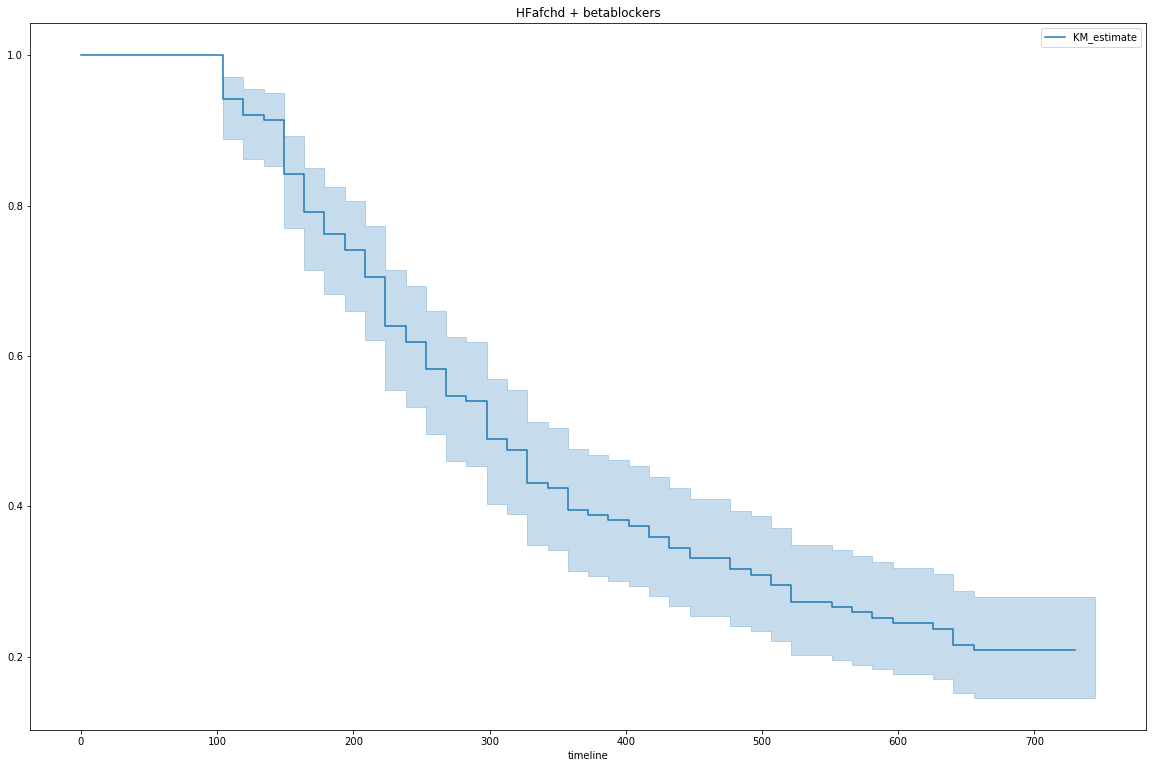

In [255]:
T6 = dataset_hfafchd_beta['gap_find']
E6 = dataset_hfafchd_beta['event']
t = np.linspace(0, 730)

kmf_hfafchd_beta = KaplanMeierFitter()
kmf_hfafchd_beta.fit(T6, event_observed=E6, timeline=t)
print("hfafchd_beta:", kmf_hfafchd_beta.median_)
kmf_hfafchd_beta.plot(title='HFafchd + betablockers')
plt.gcf().set_size_inches(20,13)

hfafchd_anti: 268.163265306


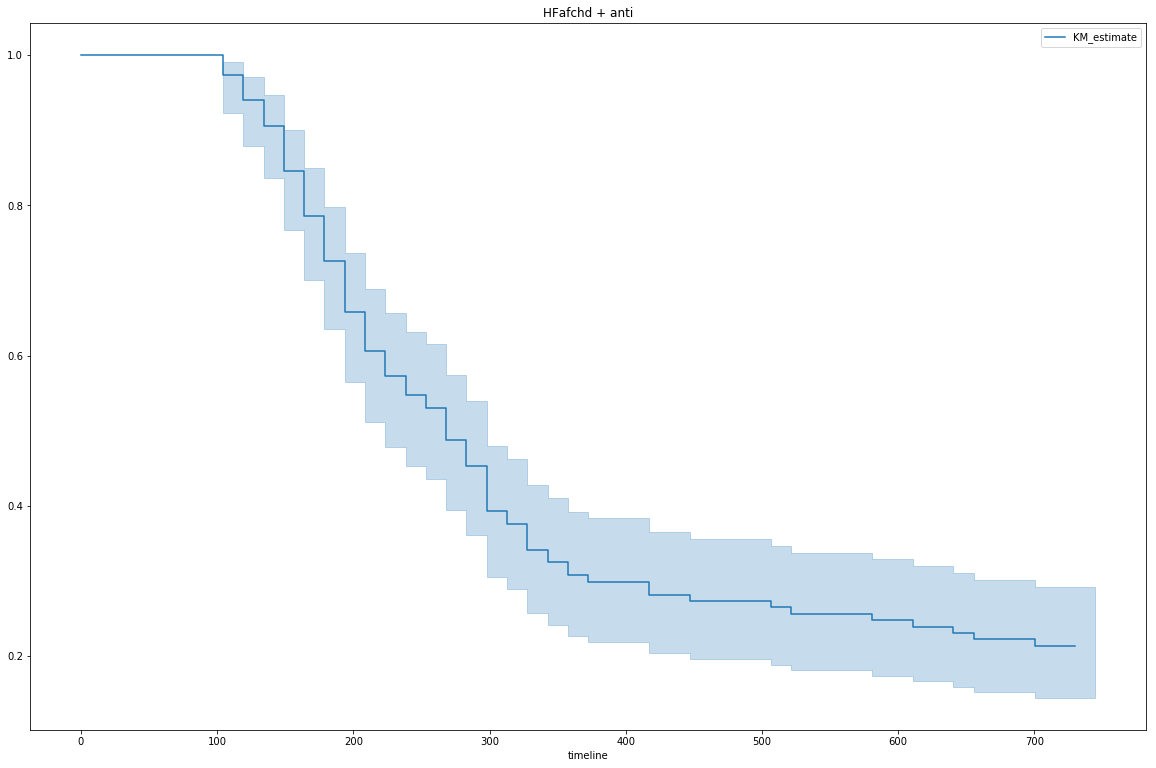

In [256]:
T7 = dataset_hfafchd_anti['gap_find']
E7 = dataset_hfafchd_anti['event']
t = np.linspace(0, 730)

kmf_hfafchd_anti = KaplanMeierFitter()
kmf_hfafchd_anti.fit(T7, event_observed=E7, timeline=t)
print("hfafchd_anti:", kmf_hfafchd_anti.median_)
kmf_hfafchd_anti.plot(title='HFafchd + anti')
plt.gcf().set_size_inches(20,13)

hfafchd_ace: 327.755102041


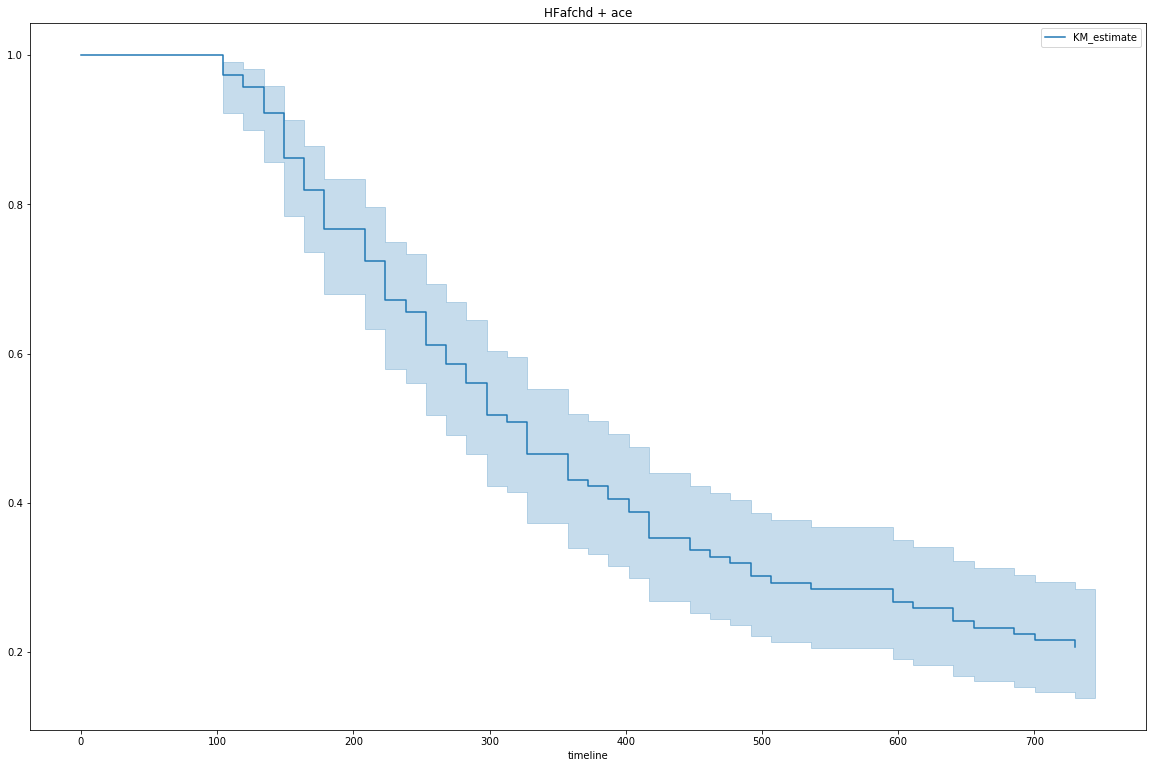

In [257]:
T8 = dataset_hfafchd_ace['gap_find']
E8 = dataset_hfafchd_ace['event']
t = np.linspace(0, 730)

kmf_hfafchd_ace = KaplanMeierFitter()
kmf_hfafchd_ace.fit(T8, event_observed=E8, timeline=t)
print("hfafchd_ace:", kmf_hfafchd_ace.median_)
kmf_hfafchd_ace.plot(title='HFafchd + ace')
plt.gcf().set_size_inches(20,13)

hfafchd_plate: 327.755102041


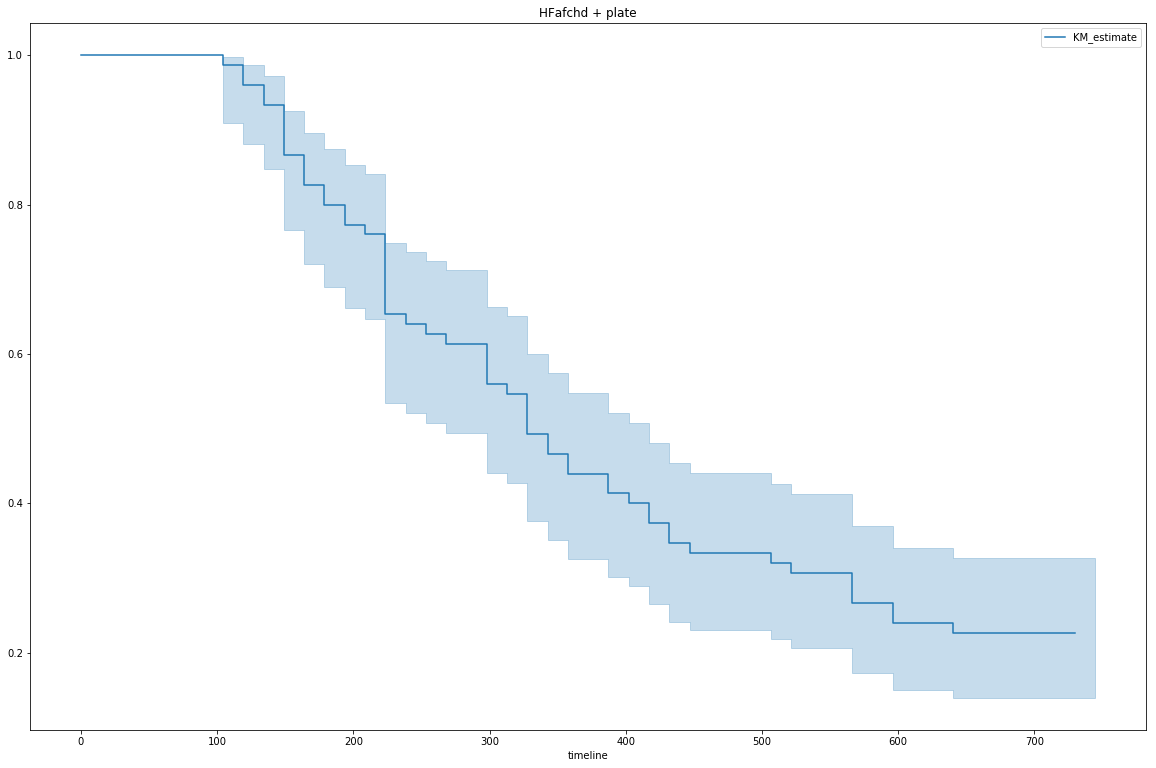

In [258]:
T9 = dataset_hfafchd_plate['gap_find']
E9 = dataset_hfafchd_plate['event']
t = np.linspace(0, 730)

kmf_hfafchd_plate = KaplanMeierFitter()
kmf_hfafchd_plate.fit(T9, event_observed=E9, timeline=t)
print("hfafchd_plate:", kmf_hfafchd_plate.median_)
kmf_hfafchd_plate.plot(title='HFafchd + plate')
plt.gcf().set_size_inches(20,13)

hfafchd_stat: 268.163265306


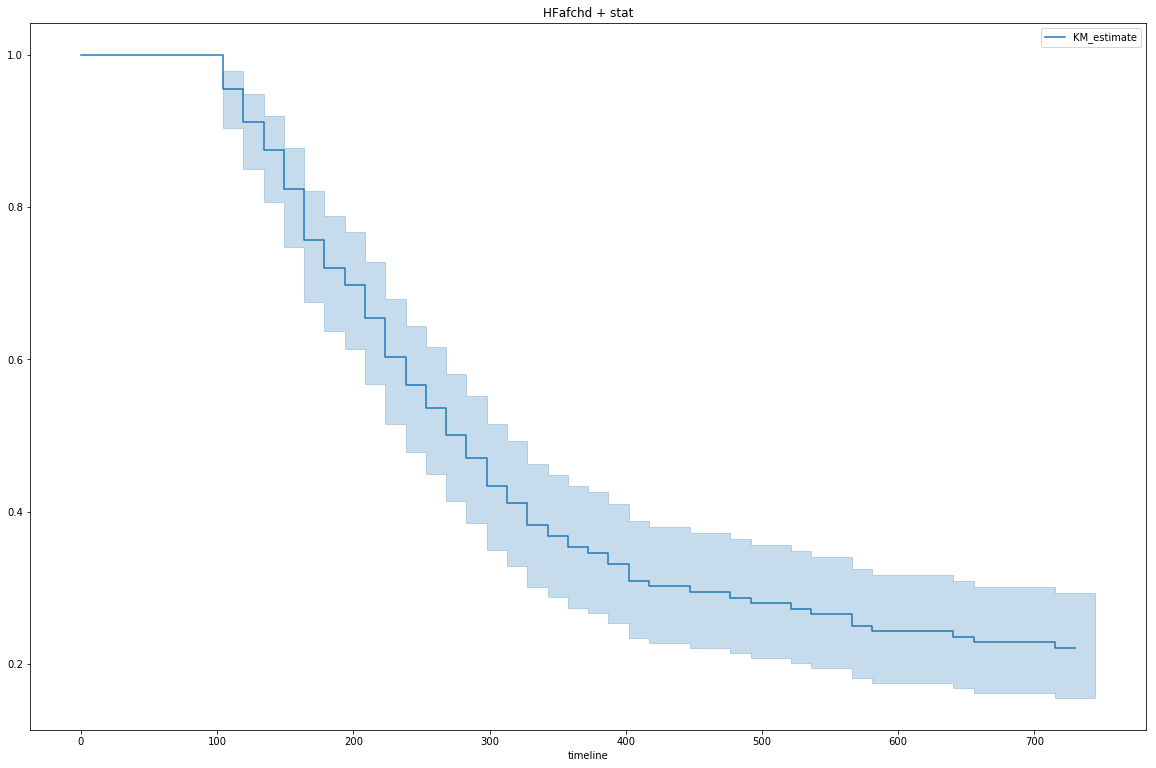

In [259]:
T10 = dataset_hfafchd_stat['gap_find']
E10 = dataset_hfafchd_stat['event']
t = np.linspace(0, 730)

kmf_hfafchd_stat = KaplanMeierFitter()
kmf_hfafchd_stat.fit(T10, event_observed=E10, timeline=t)
print("hfafchd_stat:", kmf_hfafchd_stat.median_)
kmf_hfafchd_stat.plot(title='HFafchd + stat')
plt.gcf().set_size_inches(20,13)

In [260]:
kmf_hfafchd_beta.survival_function_ = kmf_hfafchd_beta.survival_function_.reset_index()

In [261]:
kmf_hfafchd_anti.survival_function_ = kmf_hfafchd_anti.survival_function_.reset_index()

In [262]:
kmf_hfafchd_ace.survival_function_ = kmf_hfafchd_ace.survival_function_.reset_index()

In [263]:
kmf_hfafchd_plate.survival_function_ = kmf_hfafchd_plate.survival_function_.reset_index()

In [264]:
kmf_hfafchd_stat.survival_function_ = kmf_hfafchd_stat.survival_function_.reset_index()

In [265]:
type(kmf_hfafchd_beta.survival_function_)

pandas.core.frame.DataFrame

In [266]:
type(kmf_hfafchd_anti.survival_function_)

pandas.core.frame.DataFrame

In [267]:
type(kmf_hfafchd_ace.survival_function_)

pandas.core.frame.DataFrame

In [268]:
type(kmf_hfafchd_plate.survival_function_)

pandas.core.frame.DataFrame

In [269]:
type(kmf_hfafchd_stat.survival_function_)

pandas.core.frame.DataFrame

In [270]:
kmf_hfafchd_beta.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.970794,0.888214
119.183673,0.955377,0.861661
134.081633,0.950027,0.852987


In [271]:
kmf_hfafchd_beta_180 = kmf_hfafchd_beta.survival_function_.loc[kmf_hfafchd_beta.survival_function_['timeline'] > 170]
kmf_hfafchd_beta_180

,timeline,KM_estimate
12,178.775510,0.762590
13,193.673469,0.741007
14,208.571429,0.705036
15,223.469388,0.640288
16,238.367347,0.618705
17,253.265306,0.582734
18,268.163265,0.546763
19,283.061224,0.539568
20,297.959184,0.489209
21,312.857143,0.474820


In [272]:
kmf_hfafchd_anti.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.991658,0.922617
119.183673,0.971020,0.878601
134.081633,0.946801,0.836667


In [273]:
kmf_hfafchd_anti_180 = kmf_hfafchd_anti.survival_function_.loc[kmf_hfafchd_anti.survival_function_['timeline'] > 170]
kmf_hfafchd_anti_180

,timeline,KM_estimate
12,178.775510,0.726496
13,193.673469,0.658120
14,208.571429,0.606838
15,223.469388,0.572650
16,238.367347,0.547009
17,253.265306,0.529915
18,268.163265,0.487179
19,283.061224,0.452991
20,297.959184,0.393162
21,312.857143,0.376068


In [274]:
kmf_hfafchd_ace.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.991585,0.921968
119.183673,0.981829,0.899548
134.081633,0.958856,0.856206


In [275]:
kmf_hfafchd_ace_180 = kmf_hfafchd_ace.survival_function_.loc[kmf_hfafchd_ace.survival_function_['timeline'] > 170]
kmf_hfafchd_ace_180

,timeline,KM_estimate
12,178.775510,0.767241
13,193.673469,0.767241
14,208.571429,0.724138
15,223.469388,0.672414
16,238.367347,0.655172
17,253.265306,0.612069
18,268.163265,0.586207
19,283.061224,0.560345
20,297.959184,0.517241
21,312.857143,0.508621


In [276]:
kmf_hfafchd_plate.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.998111,0.909107
119.183673,0.986921,0.881102
134.081633,0.971697,0.847227


In [277]:
kmf_hfafchd_plate_180 = kmf_hfafchd_plate.survival_function_.loc[kmf_hfafchd_plate.survival_function_['timeline'] > 170]
kmf_hfafchd_plate_180

,timeline,KM_estimate
12,178.775510,0.800000
13,193.673469,0.773333
14,208.571429,0.760000
15,223.469388,0.653333
16,238.367347,0.640000
17,253.265306,0.626667
18,268.163265,0.613333
19,283.061224,0.613333
20,297.959184,0.560000
21,312.857143,0.546667


In [278]:
kmf_hfafchd_stat.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.979935,0.904440
119.183673,0.948903,0.849857
134.081633,0.920368,0.806643


In [279]:
kmf_hfafchd_stat_180 = kmf_hfafchd_stat.survival_function_.loc[kmf_hfafchd_stat.survival_function_['timeline'] > 170]
kmf_hfafchd_stat_180

,timeline,KM_estimate
12,178.775510,0.720588
13,193.673469,0.698529
14,208.571429,0.654412
15,223.469388,0.602941
16,238.367347,0.566176
17,253.265306,0.536765
18,268.163265,0.500000
19,283.061224,0.470588
20,297.959184,0.433824
21,312.857143,0.411765


### HFafchd demographics

In [280]:
cols_3 = ['patid', 'gender', 'age_group']
hfafchd_dem = pd.read_csv('HF+AF+CHD_demo_final.csv', names=cols_3, skiprows=1)
hfafchd_dem.head() 

,patid,gender,age_group
0,90788,Male,4
1,101945,Male,3
2,102649,Female,6
3,137408,Male,6
4,288593,Male,6


In [281]:
hfafchd2 = hfafchd.copy()

In [282]:
hfafchd2 = hfafchd2.reset_index()
hfafchd2.head()

,date,patid,hf_event,hf_occur,af_event,af_occur,chd_event,chd_occur,beta_event,beta_occur,anti_event,anti_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2015-09-15,90788,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,2015-09-15,90788,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,2015-09-30,90788,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,2015-09-30,90788,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,2016-01-25,90788,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [283]:
hfafchd2_patid = hfafchd2.groupby('patid')

In [284]:
results_14 = []

for patid, hfafchd2 in hfafchd2_patid:
    hfafchd2 = hfafchd2.sort_values('date')
    hfafchd2['timeline'] = (hfafchd2.iloc[-1, 0] - hfafchd2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_14.append(pd.unique(hfafchd2[['patid', 'timeline']].values.ravel('K')))  

In [285]:
data_14 = np.asarray(results_14)
hfafchd2time = pd.DataFrame({'patid':data_14[:,0], 'timeline':data_14[:,1]})
hfafchd2time.head()

,patid,timeline
0,90788.0,811.0
1,101945.0,1004.0
2,102649.0,1307.0
3,137408.0,1590.0
4,288593.0,1666.0


In [286]:
hfafchd2time_2 = hfafchd2time.loc[hfafchd2time['timeline'] > 790]
hfafchd2time_2.head()

,patid,timeline
0,90788.0,811.0
1,101945.0,1004.0
2,102649.0,1307.0
3,137408.0,1590.0
4,288593.0,1666.0


In [287]:
hfafchd2time_2.describe()

,patid,timeline
count,2.770000e+02,277.000000
mean,7.003569e+06,1509.967509
std,4.971621e+06,427.660575
min,9.078800e+04,797.000000
25%,2.994123e+06,1135.000000
50%,5.819021e+06,1478.000000
75%,1.094562e+07,1848.000000
max,1.724595e+07,2521.000000


In [288]:
hfafchd_dem_new = pd.merge(hfafchd_dem, hfafchd2time_2, on=['patid'], how='inner')
hfafchd_dem_new.head()

,patid,gender,age_group,timeline
0,90788,Male,4,811.0
1,101945,Male,3,1004.0
2,102649,Female,6,1307.0
3,137408,Male,6,1590.0
4,288593,Male,6,1666.0


In [289]:
hfafchd_dem_new['gender'].value_counts()

Male      192
Female     85
Name: gender, dtype: int64

In [290]:
hfafchd_dem_new['gender'].value_counts(normalize=True)

Male      0.693141
Female    0.306859
Name: gender, dtype: float64

In [291]:
hfafchd_dem_new['age_group'].value_counts()

6    95
5    95
4    47
7    30
3     9
2     1
Name: age_group, dtype: int64

In [292]:
hfafchd_dem_new['age_group'].value_counts(normalize=True)

6    0.342960
5    0.342960
4    0.169675
7    0.108303
3    0.032491
2    0.003610
Name: age_group, dtype: float64

## HFchd tables

In [293]:
cols4 = ['patid', 'date', 'hf_event', 'hf_occur', 'chd_event', 'chd_occur', 'beta_event', 'beta_occur', 'ace_event', 'ace_occur', 'plate_event', 'plate_occur', 'stat_event', 'stat_occur']
hfchd = pd.read_csv('HF+CHD copy.csv', parse_dates=['date'], index_col='date', names=cols4, skiprows=1)
hfchd.head() 

,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,
2015-12-06,454,0,NaN,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN
2015-06-16,454,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2015-10-09,454,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2015-08-12,454,0,NaN,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN
2016-07-14,454,1,1.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [294]:
hfchd = hfchd.fillna(0)

In [295]:
hfchd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 463038 entries, 2015-12-06 to 2017-04-05
Data columns (total 13 columns):
patid          463038 non-null int64
hf_event       463038 non-null int64
hf_occur       463038 non-null float64
chd_event      463038 non-null int64
chd_occur      463038 non-null float64
beta_event     463038 non-null int64
beta_occur     463038 non-null float64
ace_event      463038 non-null int64
ace_occur      463038 non-null float64
plate_event    463038 non-null int64
plate_occur    463038 non-null float64
stat_event     463038 non-null int64
stat_occur     463038 non-null float64
dtypes: float64(6), int64(7)
memory usage: 49.5 MB


In [296]:
hfchd['patid'].nunique()

5511

In [297]:
hfchd.head()

,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,
2015-12-06,454,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2015-06-16,454,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2015-10-09,454,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2015-08-12,454,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
2016-07-14,454,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [298]:
hfchd_beta = hfchd.loc[(hfchd['beta_event'] == 1) & (hfchd['beta_occur'] == 1.0)]
hfchd_beta.head()

,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,
2017-03-04,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2017-04-05,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2017-05-30,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2017-06-28,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2017-07-21,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0


In [299]:
hfchd_ace = hfchd.loc[(hfchd['ace_event'] == 1) & (hfchd['ace_occur'] == 1.0)]
hfchd_ace.head()

,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,
2017-03-31,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2017-04-05,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2017-05-30,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2017-06-28,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2017-07-21,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0


In [300]:
hfchd_plate = hfchd.loc[(hfchd['plate_event'] == 1) & (hfchd['plate_occur'] == 1.0)]
hfchd_plate.head()

,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,
2017-03-31,454,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2017-04-05,454,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2017-05-31,454,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2017-06-28,454,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2014-05-22,7994,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0


In [301]:
hfchd_stat = hfchd.loc[(hfchd['stat_event'] == 1) & (hfchd['stat_occur'] == 1.0)]
hfchd_stat.head()

,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
date,,,,,,,,,,,,,
2017-03-31,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2017-04-05,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2017-05-30,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2017-06-28,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2017-07-21,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0


In [302]:
hfchd_beta = hfchd_beta.reset_index()
hfchd_beta.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2017-03-04,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
1,2017-04-05,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
2,2017-05-30,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
3,2017-06-28,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
4,2017-07-21,454,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0


In [303]:
hfchd_ace = hfchd_ace.reset_index()
hfchd_ace.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2017-03-31,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
1,2017-04-05,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
2,2017-05-30,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
3,2017-06-28,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
4,2017-07-21,454,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0


In [304]:
hfchd_plate = hfchd_plate.reset_index()
hfchd_plate.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2017-03-31,454,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
1,2017-04-05,454,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
2,2017-05-31,454,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
3,2017-06-28,454,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
4,2014-05-22,7994,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0


In [305]:
hfchd_stat = hfchd_stat.reset_index()
hfchd_stat.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2017-03-31,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
1,2017-04-05,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
2,2017-05-30,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
3,2017-06-28,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0
4,2017-07-21,454,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0


### HFchd find time

In [306]:
hfchd_beta2 = hfchd_beta.copy()

In [307]:
hfchd_ace2 = hfchd_ace.copy()

In [308]:
hfchd_plate2 = hfchd_plate.copy()

In [309]:
hfchd_stat2 = hfchd_stat.copy()

In [310]:
hfchd_beta_patid2 = hfchd_beta2.groupby('patid')

In [311]:
hfchd_ace_patid2 = hfchd_ace2.groupby('patid')

In [312]:
hfchd_plate_patid2 = hfchd_plate2.groupby('patid')

In [313]:
hfchd_stat_patid2 = hfchd_stat2.groupby('patid')

In [314]:
results_11 = []

for patid, hfchd_beta2 in hfchd_beta_patid2:
    hfchd_beta2 = hfchd_beta2.sort_values('date')
    hfchd_beta2['timeline'] = (hfchd_beta2.iloc[-1, 0] - hfchd_beta2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_11.append(pd.unique(hfchd_beta2[['patid', 'timeline']].values.ravel('K')))  

In [315]:
results_12 = []

for patid, hfchd_ace2 in hfchd_ace_patid2:
    hfchd_ace2 = hfchd_ace2.sort_values('date')
    hfchd_ace2['timeline'] = (hfchd_ace2.iloc[-1, 0] - hfchd_ace2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_12.append(pd.unique(hfchd_ace2[['patid', 'timeline']].values.ravel('K')))  

In [316]:
results_13 = []

for patid, hfchd_plate2 in hfchd_plate_patid2:
    hfchd_plate2 = hfchd_plate2.sort_values('date')
    hfchd_plate2['timeline'] = (hfchd_plate2.iloc[-1, 0] - hfchd_plate2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_13.append(pd.unique(hfchd_plate2[['patid', 'timeline']].values.ravel('K')))  

In [317]:
results_14 = []

for patid, hfchd_stat2 in hfchd_stat_patid2:
    hfchd_stat2 = hfchd_stat2.sort_values('date')
    hfchd_stat2['timeline'] = (hfchd_stat2.iloc[-1, 0] - hfchd_stat2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_14.append(pd.unique(hfchd_stat2[['patid', 'timeline']].values.ravel('K')))  

In [318]:
data_11 = np.asarray(results_11)
hfchd_beta_time = pd.DataFrame({'patid':data_11[:,0], 'timeline':data_11[:,1]})
hfchd_beta_time.head()

,patid,timeline
0,454.0,171.0
1,7994.0,431.0
2,17085.0,0.0
3,17275.0,0.0
4,19607.0,0.0


In [319]:
data_12 = np.asarray(results_12)
hfchd_ace_time = pd.DataFrame({'patid':data_12[:,0], 'timeline':data_12[:,1]})
hfchd_ace_time.head()

,patid,timeline
0,454.0,147.0
1,7994.0,431.0
2,17085.0,0.0
3,17275.0,0.0
4,19607.0,0.0


In [320]:
data_13 = np.asarray(results_13)
hfchd_plate_time = pd.DataFrame({'patid':data_13[:,0], 'timeline':data_13[:,1]})
hfchd_plate_time.head()

,patid,timeline
0,454.0,89.0
1,7994.0,436.0
2,17085.0,0.0
3,17275.0,0.0
4,19607.0,0.0


In [321]:
data_14 = np.asarray(results_14)
hfchd_stat_time = pd.DataFrame({'patid':data_14[:,0], 'timeline':data_14[:,1]})
hfchd_stat_time.head()

,patid,timeline
0,454.0,144.0
1,7994.0,436.0
2,17085.0,0.0
3,17275.0,0.0
4,19607.0,0.0


In [322]:
hfchd_beta_time.describe()

,patid,timeline
count,5.484000e+03,5484.000000
mean,7.166969e+06,648.424872
std,4.873887e+06,530.611557
min,4.540000e+02,0.000000
25%,2.985269e+06,223.000000
50%,6.185571e+06,543.000000
75%,1.094975e+07,974.000000
max,1.737498e+07,2516.000000


In [323]:
hfchd_ace_time.describe()

,patid,timeline
count,5.468000e+03,5468.000000
mean,7.174671e+06,596.078456
std,4.879056e+06,515.999805
min,4.540000e+02,0.000000
25%,2.985913e+06,196.000000
50%,6.189856e+06,469.500000
75%,1.096444e+07,916.000000
max,1.737498e+07,2406.000000


In [324]:
hfchd_plate_time.describe()

,patid,timeline
count,5.487000e+03,5487.000000
mean,7.172142e+06,631.582650
std,4.877454e+06,522.884413
min,4.540000e+02,0.000000
25%,2.985826e+06,215.000000
50%,6.187223e+06,519.000000
75%,1.096113e+07,951.000000
max,1.737498e+07,2516.000000


In [325]:
hfchd_stat_time.describe()

,patid,timeline
count,5.479000e+03,5479.000000
mean,7.173988e+06,647.121555
std,4.878054e+06,527.948643
min,4.540000e+02,0.000000
25%,2.986097e+06,222.000000
50%,6.188177e+06,539.000000
75%,1.096632e+07,966.000000
max,1.737498e+07,2516.000000


In [326]:
hfchd_beta_time_2 = hfchd_beta_time.loc[hfchd_beta_time['timeline'] > 790]
hfchd_beta_time_2.head()

,patid,timeline
8,43534.0,847.0
10,55823.0,1647.0
14,66968.0,1004.0
15,72607.0,965.0
18,77299.0,997.0


In [327]:
hfchd_ace_time_2 = hfchd_ace_time.loc[hfchd_ace_time['timeline'] > 790]
hfchd_ace_time_2.head()

,patid,timeline
8,43534.0,961.0
10,55823.0,1647.0
14,66968.0,953.0
17,76915.0,1026.0
18,77299.0,997.0


In [328]:
hfchd_plate_time_2 = hfchd_plate_time.loc[hfchd_plate_time['timeline'] > 790]
hfchd_plate_time_2.head()

,patid,timeline
8,43534.0,961.0
10,55823.0,1647.0
11,60525.0,989.0
14,66968.0,1004.0
18,77299.0,997.0


In [329]:
hfchd_stat_time_2 = hfchd_stat_time.loc[hfchd_stat_time['timeline'] > 790]
hfchd_stat_time_2.head()

,patid,timeline
8,43534.0,961.0
10,55823.0,1468.0
14,66968.0,850.0
18,77299.0,997.0
20,101945.0,997.0


In [330]:
hfchd_beta_time_2.nunique()

patid       1821
timeline     888
dtype: int64

In [331]:
hfchd_ace_time_2.nunique()

patid       1606
timeline     819
dtype: int64

In [332]:
hfchd_plate_time_2.nunique()

patid       1738
timeline     845
dtype: int64

In [333]:
hfchd_stat_time_2.nunique()

patid       1803
timeline     884
dtype: int64

In [334]:
hfchd_beta_time_2.describe()

,patid,timeline
count,1.821000e+03,1821.000000
mean,6.809646e+06,1285.453597
std,4.762736e+06,364.116193
min,4.353400e+04,791.000000
25%,2.785680e+06,976.000000
50%,5.835336e+06,1233.000000
75%,1.020505e+07,1529.000000
max,1.736801e+07,2516.000000


In [335]:
hfchd_ace_time_2.describe()

,patid,timeline
count,1.606000e+03,1606.000000
mean,6.861832e+06,1274.182441
std,4.779509e+06,357.869251
min,4.353400e+04,791.000000
25%,2.835862e+06,970.000000
50%,5.909008e+06,1223.000000
75%,1.025383e+07,1489.500000
max,1.736801e+07,2406.000000


In [336]:
hfchd_plate_time_2.describe()

,patid,timeline
count,1.738000e+03,1738.000000
mean,6.904735e+06,1280.470081
std,4.788116e+06,363.206692
min,4.353400e+04,791.000000
25%,2.839842e+06,970.250000
50%,5.989410e+06,1223.000000
75%,1.032399e+07,1531.000000
max,1.736801e+07,2516.000000


In [337]:
hfchd_stat_time_2.describe()

,patid,timeline
count,1.803000e+03,1803.000000
mean,6.858760e+06,1284.113699
std,4.762058e+06,364.443601
min,4.353400e+04,791.000000
25%,2.852243e+06,970.000000
50%,5.918000e+06,1230.000000
75%,1.021664e+07,1542.500000
max,1.736801e+07,2516.000000


In [338]:
hfchd_beta_new = pd.merge(hfchd_beta, hfchd_beta_time_2, on=['patid'], how='inner')
hfchd_beta_new.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2015-09-25,43534,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,847.0
1,2015-10-16,43534,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,847.0
2,2015-11-13,43534,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,847.0
3,2015-08-12,43534,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,847.0
4,2016-05-01,43534,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,847.0


In [339]:
hfchd_ace_new = pd.merge(hfchd_ace, hfchd_ace_time_2, on=['patid'], how='inner')
hfchd_ace_new.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2015-04-20,43534,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,961.0
1,2015-05-15,43534,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,961.0
2,2015-11-06,43534,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,961.0
3,2015-10-07,43534,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,961.0
4,2015-07-08,43534,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,961.0


In [340]:
hfchd_plate_new = pd.merge(hfchd_plate, hfchd_plate_time_2, on=['patid'], how='inner')
hfchd_plate_new.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2015-04-20,43534,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,961.0
1,2015-05-15,43534,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,961.0
2,2015-11-06,43534,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,961.0
3,2015-10-07,43534,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,961.0
4,2015-07-08,43534,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0,961.0


In [341]:
hfchd_stat_new = pd.merge(hfchd_stat, hfchd_stat_time_2, on=['patid'], how='inner')
hfchd_stat_new.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur,timeline
0,2015-04-20,43534,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,961.0
1,2015-05-15,43534,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,961.0
2,2015-11-06,43534,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,961.0
3,2015-10-07,43534,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,961.0
4,2015-07-08,43534,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1.0,961.0


In [342]:
type(hfchd_beta_new)

pandas.core.frame.DataFrame

In [343]:
type(hfchd_ace_new)

pandas.core.frame.DataFrame

In [344]:
type(hfchd_plate_new)

pandas.core.frame.DataFrame

In [345]:
type(hfchd_stat_new)

pandas.core.frame.DataFrame

In [346]:
hfchd_beta_new_patid = hfchd_beta_new.groupby('patid')

In [347]:
hfchd_ace_new_patid = hfchd_ace_new.groupby('patid')

In [348]:
hfchd_plate_new_patid = hfchd_plate_new.groupby('patid')

In [349]:
hfchd_stat_new_patid = hfchd_stat_new.groupby('patid')

In [350]:
type(hfchd_beta_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [351]:
type(hfchd_ace_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [352]:
type(hfchd_plate_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [353]:
type(hfchd_stat_new_patid)

pandas.core.groupby.DataFrameGroupBy

In [354]:
results11 = []

for patid, hfchd_beta in hfchd_beta_new_patid:
    hfchd_beta = hfchd_beta.sort_values('date')
    hfchd_beta['gap'] = hfchd_beta.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfchd_beta.loc[hfchd_beta['gap'] > 90]
    
    if gap_find.empty == True:
        hfchd_beta['gap_find'] = 730 
        hfchd_beta['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfchd_beta['gap_find'] = (gap_find_date - hfchd_beta.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfchd_beta['event'] = 1
        
    results11.append(pd.unique(hfchd_beta[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [355]:
results12 = []

for patid, hfchd_ace in hfchd_ace_new_patid:
    hfchd_ace = hfchd_ace.sort_values('date')
    hfchd_ace['gap'] = hfchd_ace.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfchd_ace.loc[hfchd_ace['gap'] > 90]
    
    if gap_find.empty == True:
        hfchd_ace['gap_find'] = 730 
        hfchd_ace['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfchd_ace['gap_find'] = (gap_find_date - hfchd_ace.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfchd_ace['event'] = 1
        
    results12.append(pd.unique(hfchd_ace[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [356]:
results13 = []

for patid, hfchd_plate in hfchd_plate_new_patid:
    hfchd_plate = hfchd_plate.sort_values('date')
    hfchd_plate['gap'] = hfchd_plate.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfchd_plate.loc[hfchd_plate['gap'] > 90]
    
    if gap_find.empty == True:
        hfchd_plate['gap_find'] = 730 
        hfchd_plate['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfchd_plate['gap_find'] = (gap_find_date - hfchd_plate.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfchd_plate['event'] = 1
        
    results13.append(pd.unique(hfchd_plate[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [357]:
results14 = []

for patid, hfchd_stat in hfchd_stat_new_patid:
    hfchd_stat = hfchd_stat.sort_values('date')
    hfchd_stat['gap'] = hfchd_stat.date.diff() / pd.Timedelta(1, unit='d')
    
    gap_find = hfchd_stat.loc[hfchd_stat['gap'] > 90]
    
    if gap_find.empty == True:
        hfchd_stat['gap_find'] = 730 
        hfchd_stat['event'] = 0
    
    else:
        gap_find_date = gap_find.sort_values('date').iloc[0,0]
        hfchd_stat['gap_find'] = (gap_find_date - hfchd_stat.iloc[0, 0]) / pd.Timedelta(1, unit='d')
        hfchd_stat['event'] = 1
        
    results14.append(pd.unique(hfchd_stat[['patid', 'gap_find', 'event']].values.ravel('K')))  

In [358]:
data11 = np.asarray(results11)
print(data11)

[[43534 713.0 1]
 [55823 730 0]
 [66968 102.0 1]
 ..., 
 [17355629 272.0 1]
 [17365849 518.0 1]
 [17368011 247.0 1]]


In [359]:
data12 = np.asarray(results12)
print(data12)

[[43534 827.0 1]
 [55823 730 0]
 [66968 185.0 1]
 ..., 
 [17343992 133.0 1]
 [17355629 310.0 1]
 [17368011 247.0 1]]


In [360]:
data13 = np.asarray(results13)
print(data13)

[[43534 827.0 1]
 [55823 730 0]
 [60525 119.0 1]
 ..., 
 [17355629 310.0 1]
 [17365849 506.0 1]
 [17368011 247.0 1]]


In [361]:
data14 = np.asarray(results14)
print(data14)

[[43534 827.0 1]
 [55823 111.0 1]
 [66968 102.0 1]
 ..., 
 [17355629 310.0 1]
 [17365849 465.0 1]
 [17368011 247.0 1]]


In [362]:
dataset_hfchd_beta = pd.DataFrame({'patid':data11[:,0],'gap_find':data11[:,1],'event':data11[:,2] })
dataset_hfchd_beta.head()

,event,gap_find,patid
0,1,713,43534
1,0,730,55823
2,1,102,66968
3,1,376,72607
4,0,730,77299


In [363]:
dataset_hfchd_ace = pd.DataFrame({'patid':data12[:,0],'gap_find':data12[:,1],'event':data12[:,2] })
dataset_hfchd_ace.head()

,event,gap_find,patid
0,1,827,43534
1,0,730,55823
2,1,185,66968
3,1,242,76915
4,0,730,77299


In [364]:
dataset_hfchd_plate = pd.DataFrame({'patid':data13[:,0],'gap_find':data13[:,1],'event':data13[:,2] })
dataset_hfchd_plate.head()

,event,gap_find,patid
0,1,827,43534
1,0,730,55823
2,1,119,60525
3,1,102,66968
4,0,730,77299


In [365]:
dataset_hfchd_stat = pd.DataFrame({'patid':data14[:,0],'gap_find':data14[:,1],'event':data14[:,2] })
dataset_hfchd_stat.head()

,event,gap_find,patid
0,1,827,43534
1,1,111,55823
2,1,102,66968
3,0,730,77299
4,1,349,101945


In [366]:
dataset_hfchd_beta.patid.nunique()

1821

In [367]:
dataset_hfchd_ace.patid.nunique()

1606

In [368]:
dataset_hfchd_plate.patid.nunique()

1738

In [369]:
dataset_hfchd_stat.patid.nunique()

1803

hfchd_beta: 283.06122449


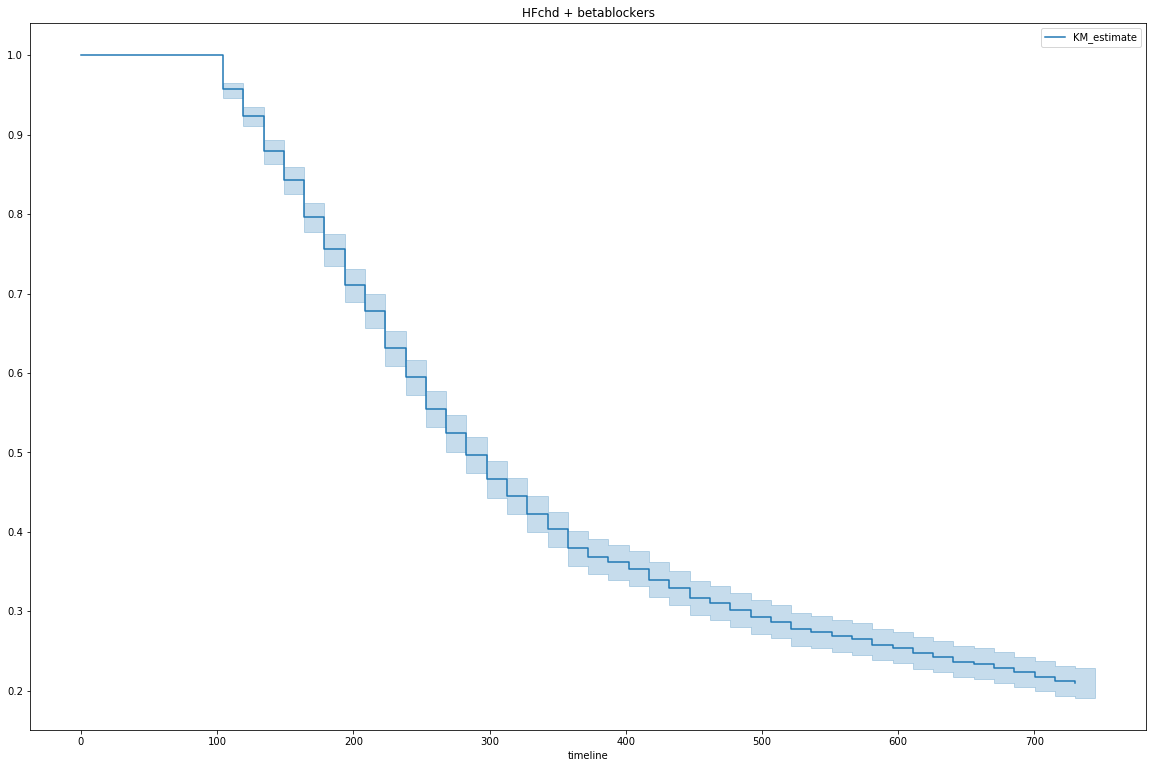

In [370]:
T11 = dataset_hfchd_beta['gap_find']
E11 = dataset_hfchd_beta['event']
t = np.linspace(0, 730)

kmf_hfchd_beta = KaplanMeierFitter()
kmf_hfchd_beta.fit(T11, event_observed=E11, timeline=t)
print("hfchd_beta:", kmf_hfchd_beta.median_)
kmf_hfchd_beta.plot(title='HFchd + betablockers')
plt.gcf().set_size_inches(20,13)

hfchd_ace: 297.959183673


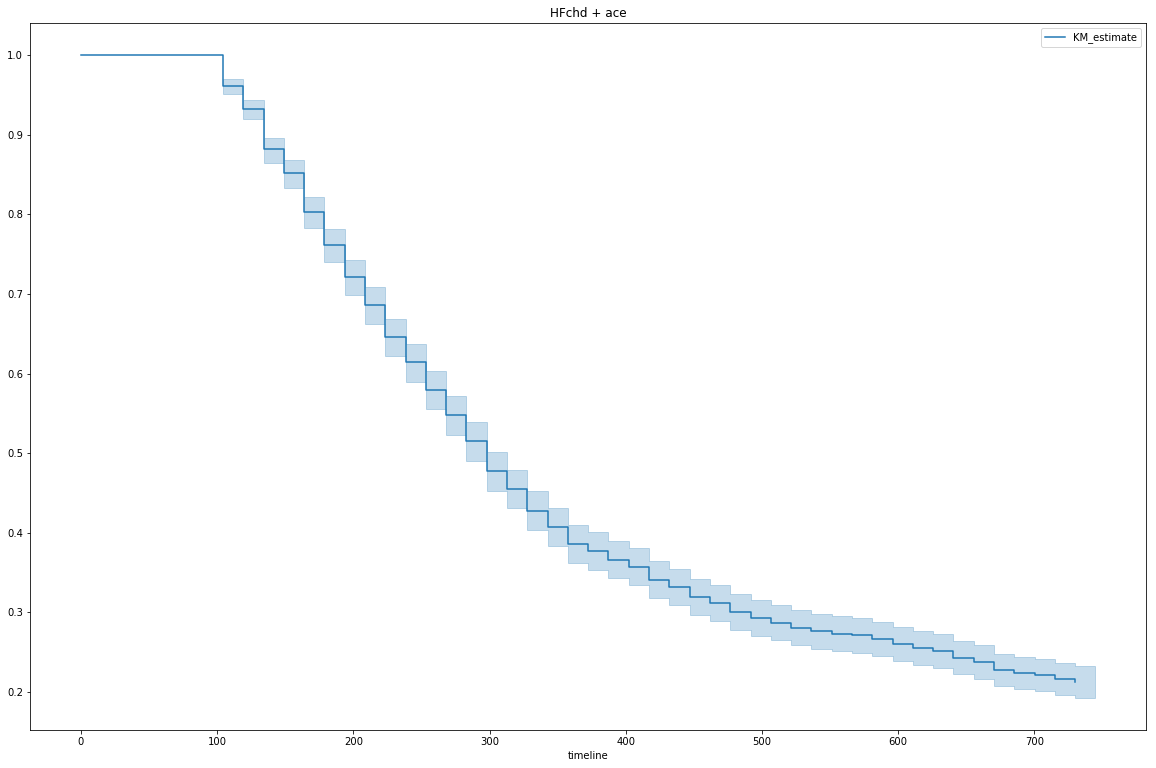

In [371]:
T12 = dataset_hfchd_ace['gap_find']
E12 = dataset_hfchd_ace['event']
t = np.linspace(0, 730)

kmf_hfchd_ace = KaplanMeierFitter()
kmf_hfchd_ace.fit(T12, event_observed=E12, timeline=t)
print("hfchd_ace:", kmf_hfchd_ace.median_)
kmf_hfchd_ace.plot(title='HFchd + ace')
plt.gcf().set_size_inches(20,13)

hfchd_plate: 297.959183673


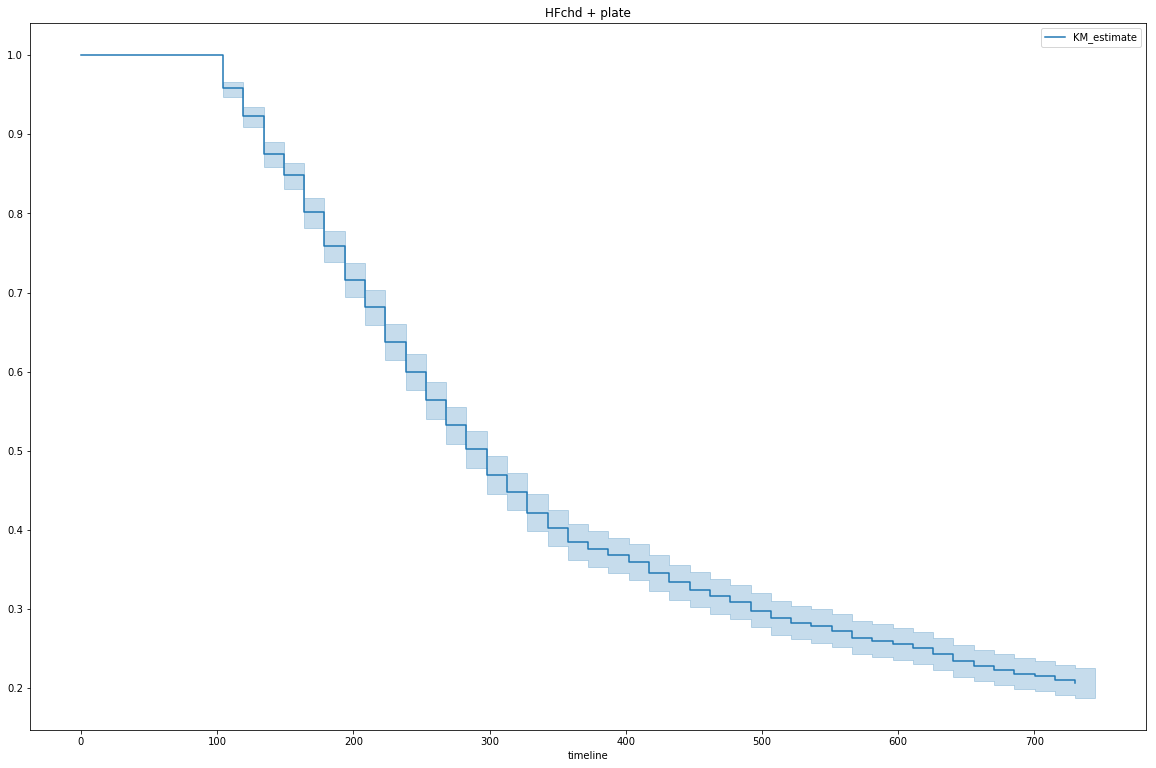

In [372]:
T13 = dataset_hfchd_plate['gap_find']
E13 = dataset_hfchd_plate['event']
t = np.linspace(0, 730)

kmf_hfchd_plate = KaplanMeierFitter()
kmf_hfchd_plate.fit(T13, event_observed=E13, timeline=t)
print("hfchd_plate:", kmf_hfchd_plate.median_)
kmf_hfchd_plate.plot(title='HFchd + plate')
plt.gcf().set_size_inches(20,13)

hfchd_stat: 283.06122449


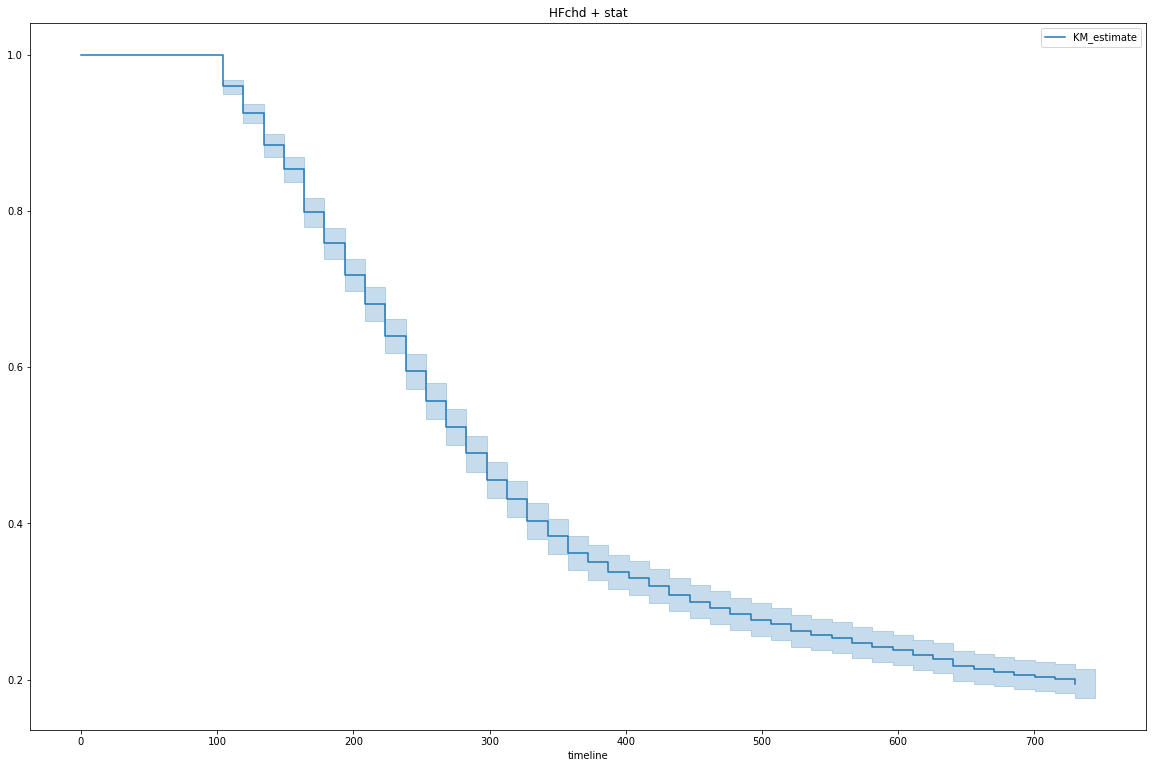

In [373]:
T14 = dataset_hfchd_stat['gap_find']
E14 = dataset_hfchd_stat['event']
t = np.linspace(0, 730)

kmf_hfchd_stat = KaplanMeierFitter()
kmf_hfchd_stat.fit(T14, event_observed=E14, timeline=t)
print("hfchd_stat:", kmf_hfchd_stat.median_)
kmf_hfchd_stat.plot(title='HFchd + stat')
plt.gcf().set_size_inches(20,13)

In [374]:
kmf_hfchd_beta.survival_function_ = kmf_hfchd_beta.survival_function_.reset_index()

In [375]:
kmf_hfchd_ace.survival_function_ = kmf_hfchd_ace.survival_function_.reset_index()

In [376]:
kmf_hfchd_plate.survival_function_ = kmf_hfchd_plate.survival_function_.reset_index()

In [377]:
kmf_hfchd_stat.survival_function_ = kmf_hfchd_stat.survival_function_.reset_index()

In [378]:
type(kmf_hfchd_beta.survival_function_)

pandas.core.frame.DataFrame

In [379]:
type(kmf_hfchd_ace.survival_function_)

pandas.core.frame.DataFrame

In [380]:
type(kmf_hfchd_plate.survival_function_)

pandas.core.frame.DataFrame

In [381]:
type(kmf_hfchd_stat.survival_function_)

pandas.core.frame.DataFrame

In [382]:
kmf_hfchd_beta.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.965543,0.946810
119.183673,0.934973,0.910495
134.081633,0.893321,0.863328


In [383]:
kmf_hfchd_beta_180 = kmf_hfchd_beta.survival_function_.loc[kmf_hfchd_beta.survival_function_['timeline'] > 170]
kmf_hfchd_beta_180

,timeline,KM_estimate
12,178.775510,0.755629
13,193.673469,0.710599
14,208.571429,0.678199
15,223.469388,0.631521
16,238.367347,0.594728
17,253.265306,0.555189
18,268.163265,0.524437
19,283.061224,0.496980
20,297.959184,0.466227
21,312.857143,0.445360


In [384]:
kmf_hfchd_ace.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.969772,0.950756
119.183673,0.943982,0.919369
134.081633,0.896541,0.864881


In [385]:
kmf_hfchd_ace_180 = kmf_hfchd_ace.survival_function_.loc[kmf_hfchd_ace.survival_function_['timeline'] > 170]
kmf_hfchd_ace_180

,timeline,KM_estimate
12,178.775510,0.762142
13,193.673469,0.721669
14,208.571429,0.686177
15,223.469388,0.646326
16,238.367347,0.613948
17,253.265306,0.579701
18,268.163265,0.547945
19,283.061224,0.514944
20,297.959184,0.477584
21,312.857143,0.455168


In [386]:
kmf_hfchd_plate.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.966462,0.947456
119.183673,0.934509,0.909335
134.081633,0.890360,0.859283


In [387]:
kmf_hfchd_plate_180 = kmf_hfchd_plate.survival_function_.loc[kmf_hfchd_plate.survival_function_['timeline'] > 170]
kmf_hfchd_plate_180

,timeline,KM_estimate
12,178.775510,0.758918
13,193.673469,0.716341
14,208.571429,0.681818
15,223.469388,0.637514
16,238.367347,0.600115
17,253.265306,0.563867
18,268.163265,0.532221
19,283.061224,0.501726
20,297.959184,0.469505
21,312.857143,0.448216


In [388]:
kmf_hfchd_stat.confidence_interval_

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.000000,NaN,NaN
14.897959,NaN,NaN
29.795918,NaN,NaN
44.693878,NaN,NaN
59.591837,NaN,NaN
74.489796,NaN,NaN
89.387755,NaN,NaN
104.285714,0.968171,0.949953
119.183673,0.937396,0.913176
134.081633,0.898532,0.868982


In [389]:
kmf_hfchd_stat_180 = kmf_hfchd_stat.survival_function_.loc[kmf_hfchd_stat.survival_function_['timeline'] > 170]
kmf_hfchd_stat_180

,timeline,KM_estimate
12,178.775510,0.759290
13,193.673469,0.718802
14,208.571429,0.681642
15,223.469388,0.640599
16,238.367347,0.595119
17,253.265306,0.557404
18,268.163265,0.523572
19,283.061224,0.489739
20,297.959184,0.455352
21,312.857143,0.431503


### HFchd demographics

In [390]:
cols_4 = ['patid', 'gender', 'age_group']
hfchd_dem = pd.read_csv('HF+CHD_demo copy.csv', names=cols_4, skiprows=1)
hfchd_dem.head() 

,patid,gender,age_group
0,454,Female,6
1,7994,Male,4
2,17085,Male,6
3,17275,Male,5
4,19607,Female,4


In [391]:
hfchd2 = hfchd.copy()

In [392]:
hfchd2 = hfchd2.reset_index()
hfchd2.head()

,date,patid,hf_event,hf_occur,chd_event,chd_occur,beta_event,beta_occur,ace_event,ace_occur,plate_event,plate_occur,stat_event,stat_occur
0,2015-12-06,454,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
1,2015-06-16,454,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,2015-10-09,454,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,2015-08-12,454,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0
4,2016-07-14,454,1,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [393]:
hfchd2_patid = hfchd2.groupby('patid')

In [394]:
results_15 = []

for patid, hfchd2 in hfchd2_patid:
    hfchd2 = hfchd2.sort_values('date')
    hfchd2['timeline'] = (hfchd2.iloc[-1, 0] - hfchd2.iloc[0, 0]) / pd.Timedelta(1, unit='d')

    results_15.append(pd.unique(hfchd2[['patid', 'timeline']].values.ravel('K')))  

In [395]:
data_15 = np.asarray(results_15)
hfchd2time = pd.DataFrame({'patid':data_15[:,0], 'timeline':data_15[:,1]})
hfchd2time.head()

,patid,timeline
0,454.0,801.0
1,7994.0,468.0
2,17085.0,1364.0
3,17275.0,208.0
4,19607.0,242.0


In [396]:
hfchd2time_2 = hfchd2time.loc[hfchd2time['timeline'] > 790]
hfchd2time_2.head()

,patid,timeline
0,454.0,801.0
2,17085.0,1364.0
5,21241.0,1534.0
6,34092.0,1166.0
8,43534.0,1212.0


In [397]:
hfchd2time_2.describe()

,patid,timeline
count,3.521000e+03,3521.000000
mean,7.024028e+06,1443.847487
std,4.826551e+06,422.690711
min,4.540000e+02,791.000000
25%,2.923702e+06,1055.000000
50%,6.011518e+06,1394.000000
75%,1.065568e+07,1768.000000
max,1.737498e+07,2521.000000


In [398]:
hfchd_dem_new = pd.merge(hfchd_dem, hfchd2time_2, on=['patid'], how='inner')
hfchd_dem_new.head()

,patid,gender,age_group,timeline
0,454,Female,6,801.0
1,17085,Male,6,1364.0
2,21241,Male,7,1534.0
3,34092,Male,6,1166.0
4,43534,Male,6,1212.0


In [399]:
hfchd_dem_new['gender'].value_counts()

Male      2518
Female    1003
Name: gender, dtype: int64

In [400]:
hfchd_dem_new['gender'].value_counts(normalize=True)

Male      0.715138
Female    0.284862
Name: gender, dtype: float64

In [401]:
hfchd_dem_new['age_group'].value_counts()

5    1055
6     908
4     781
3     381
7     264
2     109
1      14
8       9
Name: age_group, dtype: int64

In [402]:
hfchd_dem_new['age_group'].value_counts(normalize=True)

5    0.299631
6    0.257881
4    0.221812
3    0.108208
7    0.074979
2    0.030957
1    0.003976
8    0.002556
Name: age_group, dtype: float64

## Demographic table

In [403]:
hfchd_dem_new['condition'] = 'hfchd'
hfchd_dem_new.head()

,patid,gender,age_group,timeline,condition
0,454,Female,6,801.0,hfchd
1,17085,Male,6,1364.0,hfchd
2,21241,Male,7,1534.0,hfchd
3,34092,Male,6,1166.0,hfchd
4,43534,Male,6,1212.0,hfchd


In [404]:
hf_dem_new['condition'] = 'hf'
hf_dem_new.head()

,patid,gender,age_group,timeline,condition
0,454,Female,6,801.0,hf
1,929,Male,6,1140.0,hf
2,2280,Female,7,1024.0,hf
3,17085,Male,6,1086.0,hf
4,21241,Male,7,1437.0,hf


In [405]:
hfaf_dem_new['condition'] = 'hfaf'
hfaf_dem_new.head()

,patid,gender,age_group,timeline,condition
0,929,Male,6,1140.0,hfaf
1,2280,Female,7,1024.0,hfaf
2,12099,Male,5,915.0,hfaf
3,21241,Male,7,1437.0,hfaf
4,38312,Male,5,1726.0,hfaf


In [406]:
hfafchd_dem_new['condition'] = 'hfafchd'
hfafchd_dem_new.head()

,patid,gender,age_group,timeline,condition
0,90788,Male,4,811.0,hfafchd
1,101945,Male,3,1004.0,hfafchd
2,102649,Female,6,1307.0,hfafchd
3,137408,Male,6,1590.0,hfafchd
4,288593,Male,6,1666.0,hfafchd


In [407]:
demo_table = pd.concat([hf_dem_new, hfaf_dem_new, hfchd_dem_new, hfafchd_dem_new], ignore_index=True)

In [408]:
demo_table.to_csv('demo_table.csv')

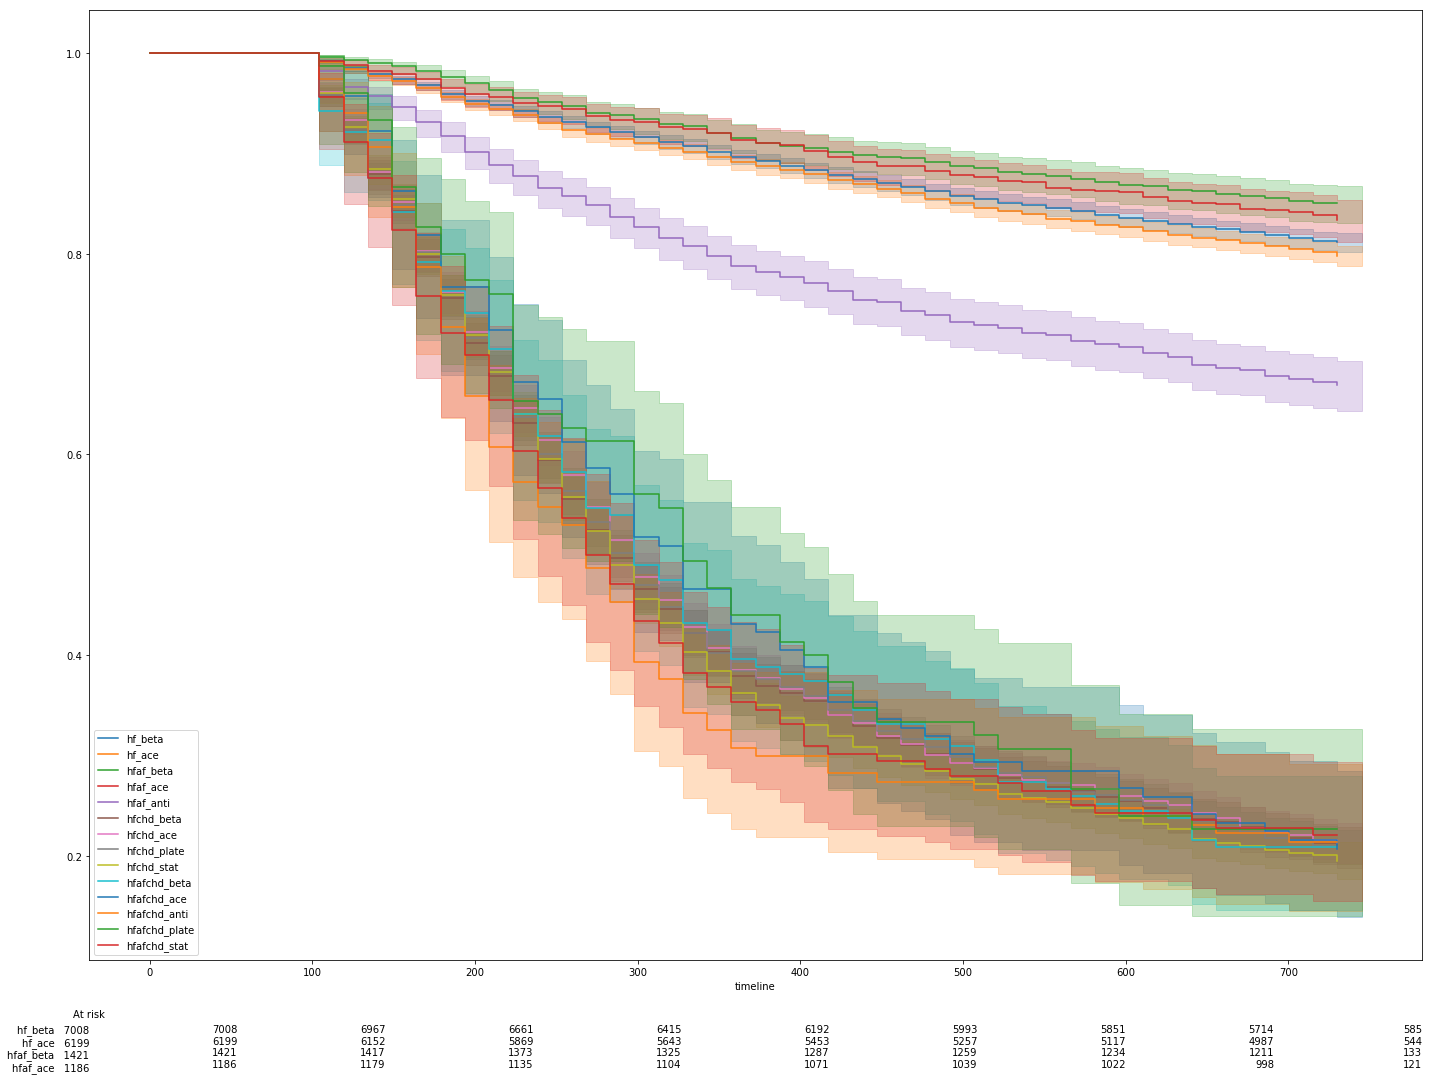

In [409]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(20,15))
ax = f.add_subplot(111)

kmf_hf_beta = KaplanMeierFitter()
ax = kmf_hf_beta.fit(T1, event_observed=E1, label='hf_beta', timeline=t).plot(ax=ax)

kmf_hf_ace = KaplanMeierFitter()
ax = kmf_hf_ace.fit(T2, event_observed=E2, label='hf_ace', timeline=t).plot(ax=ax)

kmf_hfaf_beta = KaplanMeierFitter()
ax = kmf_hfaf_beta.fit(T3, event_observed=E3, label='hfaf_beta', timeline=t).plot(ax=ax)

kmf_hfaf_ace = KaplanMeierFitter()
ax = kmf_hfaf_ace.fit(T5, event_observed=E5, label='hfaf_ace', timeline=t).plot(ax=ax)

kmf_hfaf_anti = KaplanMeierFitter()
ax = kmf_hfaf_anti.fit(T4, event_observed=E4, label='hfaf_anti', timeline=t).plot(ax=ax)

kmf_hfchd_beta = KaplanMeierFitter()
ax = kmf_hfchd_beta.fit(T11, event_observed=E11, label='hfchd_beta', timeline=t).plot(ax=ax)

kmf_hfchd_ace = KaplanMeierFitter()
kmf_hfchd_ace.fit(T12, event_observed=E12, label='hfchd_ace', timeline=t).plot(ax=ax)

kmf_hfchd_plate = KaplanMeierFitter()
ax = kmf_hfchd_plate.fit(T13, event_observed=E13, label='hfchd_plate', timeline=t).plot(ax=ax)

kmf_hfchd_stat = KaplanMeierFitter()
kmf_hfchd_stat.fit(T14, event_observed=E14, label='hfchd_stat', timeline=t).plot(ax=ax)

kmf_hfafchd_beta = KaplanMeierFitter()
ax = kmf_hfafchd_beta.fit(T6, event_observed=E6, label='hfafchd_beta', timeline=t).plot(ax=ax)

kmf_hfafchd_ace = KaplanMeierFitter()
ax = kmf_hfafchd_ace.fit(T8, event_observed=E8, label='hfafchd_ace', timeline=t).plot(ax=ax)

kmf_hfafchd_anti = KaplanMeierFitter()
ax = kmf_hfafchd_anti.fit(T7, event_observed=E7, label='hfafchd_anti', timeline=t).plot(ax=ax)

kmf_hfafchd_plate = KaplanMeierFitter()
ax = kmf_hfafchd_plate.fit(T9, event_observed=E9, label='hfafchd_plate', timeline=t).plot(ax=ax)

kmf_hfafchd_stat = KaplanMeierFitter()
ax = kmf_hfafchd_stat.fit(T10, event_observed=E10, label='hfafchd_stat', timeline=t).plot(ax=ax)

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hf_beta, kmf_hf_ace, kmf_hfaf_beta, kmf_hfaf_ace, ax=ax)

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


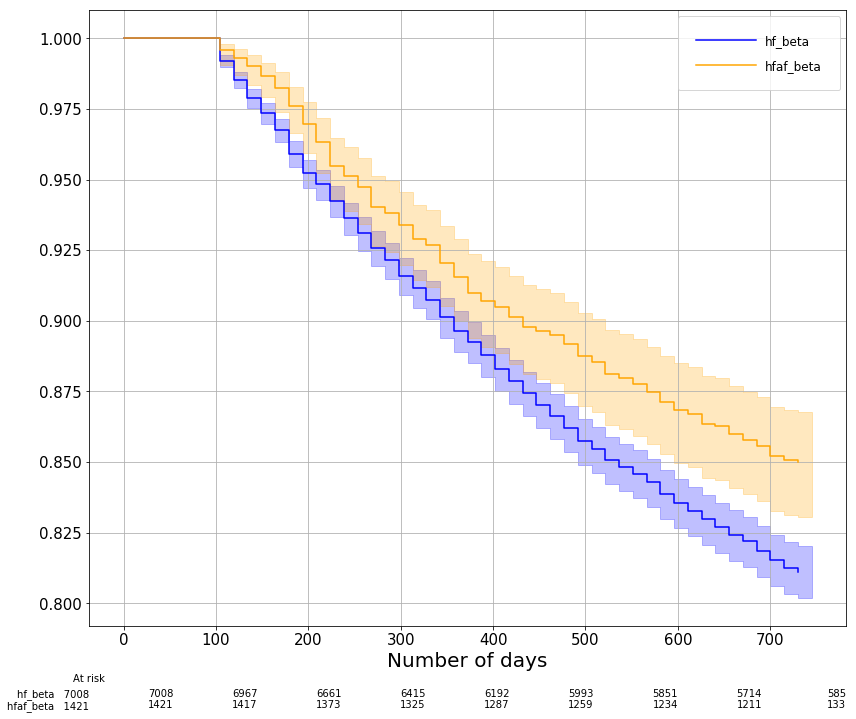

In [517]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hf_beta = KaplanMeierFitter()
ax = kmf_hf_beta.fit(T1, event_observed=E1, label='hf_beta', timeline=t).plot(ax=ax, color='blue')

kmf_hfaf_beta = KaplanMeierFitter()
ax = kmf_hfaf_beta.fit(T3, event_observed=E3, label='hfaf_beta', timeline=t).plot(ax=ax, color='orange')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hf_beta, kmf_hfaf_beta, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


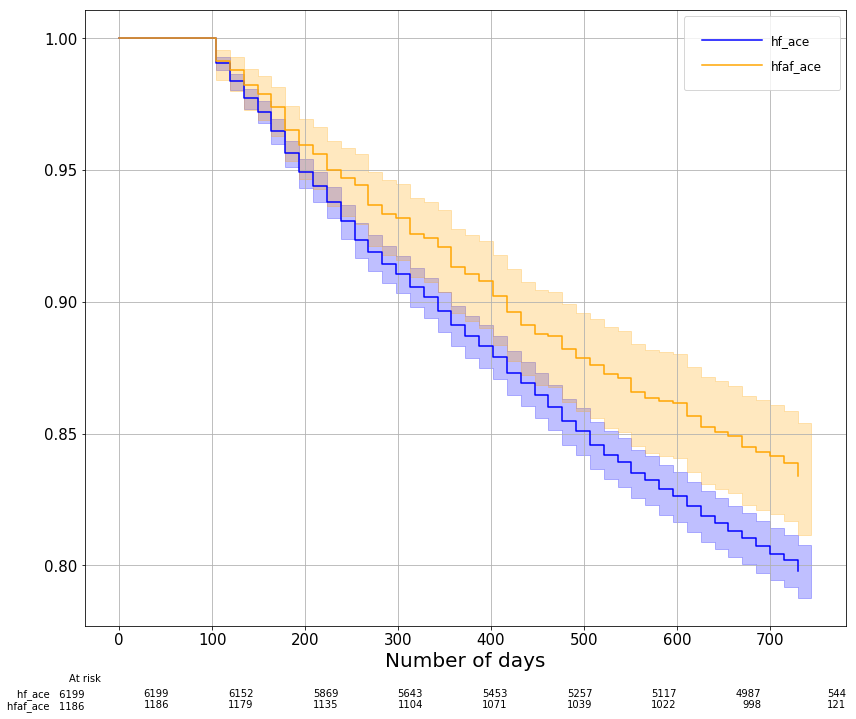

In [522]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hf_ace = KaplanMeierFitter()
ax = kmf_hf_ace.fit(T2, event_observed=E2, label='hf_ace', timeline=t).plot(ax=ax, color='blue')

kmf_hfaf_ace = KaplanMeierFitter()
ax = kmf_hfaf_ace.fit(T5, event_observed=E5, label='hfaf_ace', timeline=t).plot(ax=ax, color='orange')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hf_ace, kmf_hfaf_ace)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

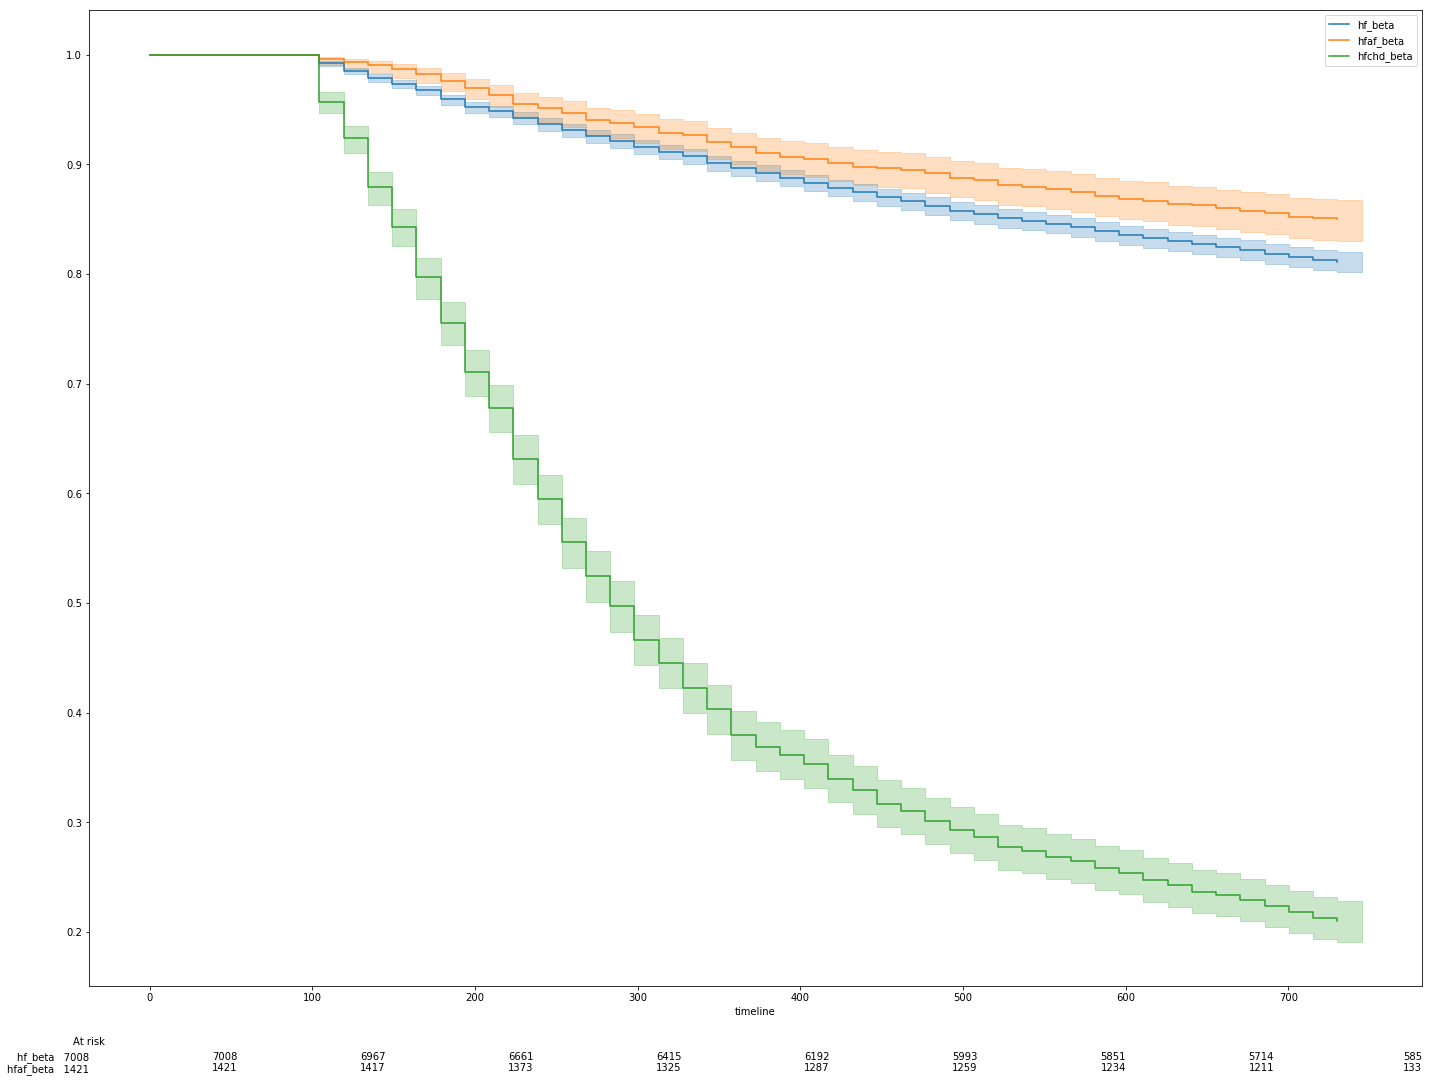

In [410]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(20,15))
ax = f.add_subplot(111)

kmf_hf_beta = KaplanMeierFitter()
ax = kmf_hf_beta.fit(T1, event_observed=E1, label='hf_beta', timeline=t).plot(ax=ax)

kmf_hfaf_beta = KaplanMeierFitter()
ax = kmf_hfaf_beta.fit(T3, event_observed=E3, label='hfaf_beta', timeline=t).plot(ax=ax)

kmf_hfchd_beta = KaplanMeierFitter()
ax = kmf_hfchd_beta.fit(T11, event_observed=E11, label='hfchd_beta', timeline=t).plot(ax=ax)


from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hf_beta, kmf_hfaf_beta, ax=ax)

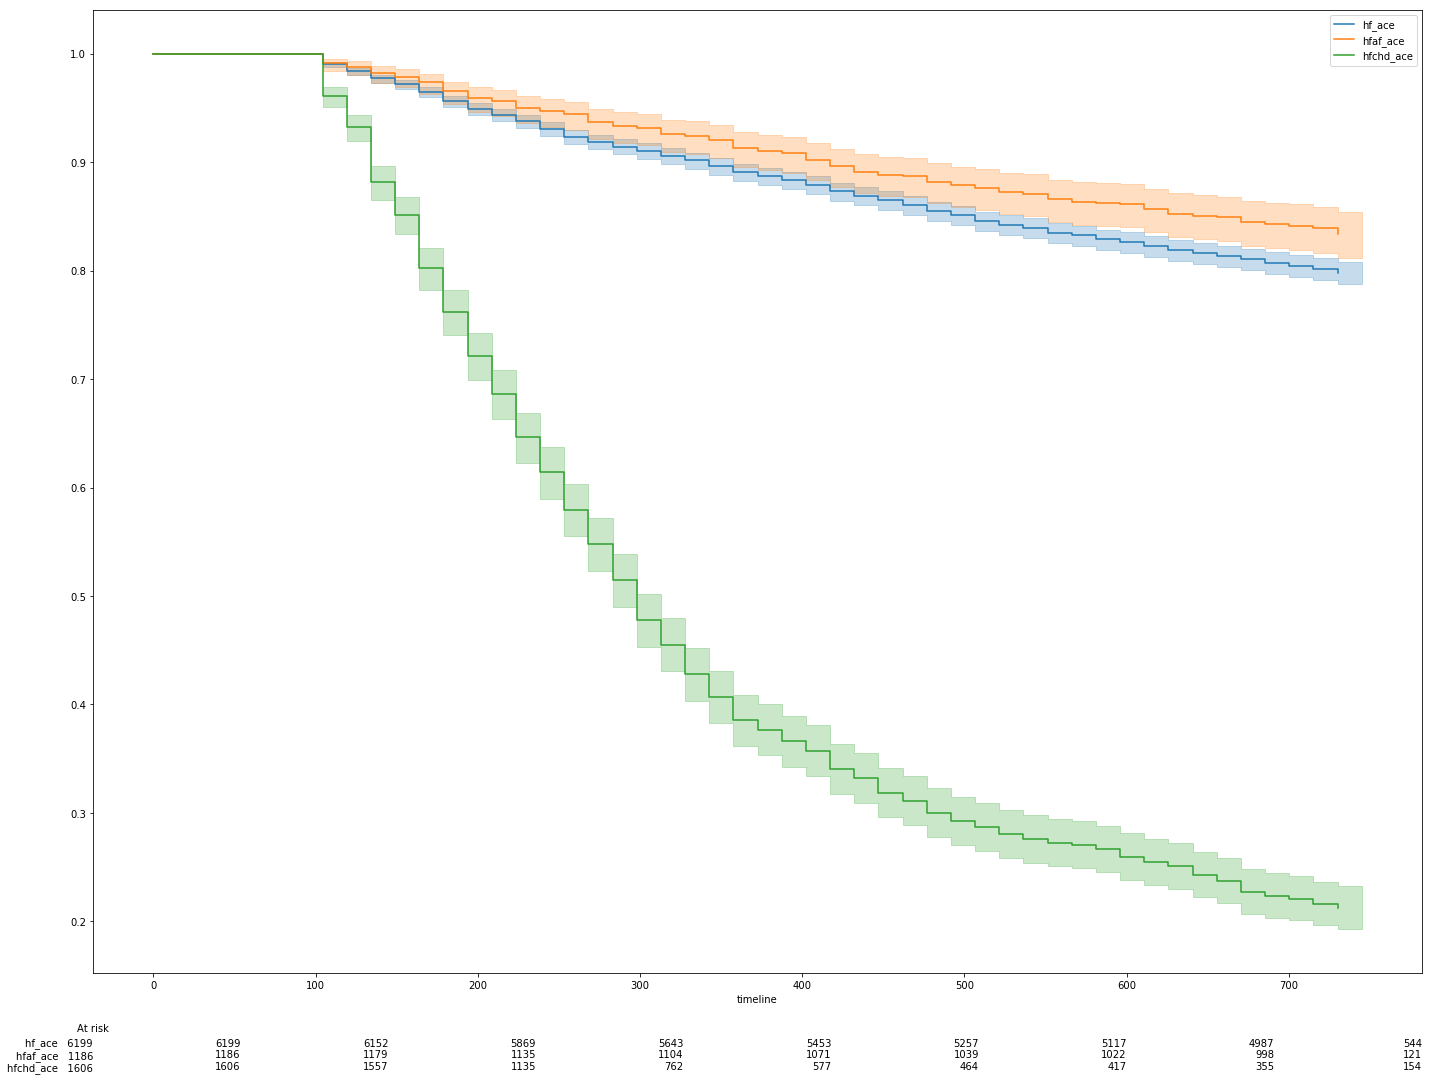

In [411]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(20,15))
ax = f.add_subplot(111)

kmf_hf_ace = KaplanMeierFitter()
ax = kmf_hf_ace.fit(T2, event_observed=E2, label='hf_ace', timeline=t).plot(ax=ax)

kmf_hfaf_ace = KaplanMeierFitter()
ax = kmf_hfaf_ace.fit(T5, event_observed=E5, label='hfaf_ace', timeline=t).plot(ax=ax)

kmf_hfchd_ace = KaplanMeierFitter()
kmf_hfchd_ace.fit(T12, event_observed=E12, label='hfchd_ace', timeline=t).plot(ax=ax)

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hf_ace, kmf_hfaf_ace, kmf_hfchd_ace)

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


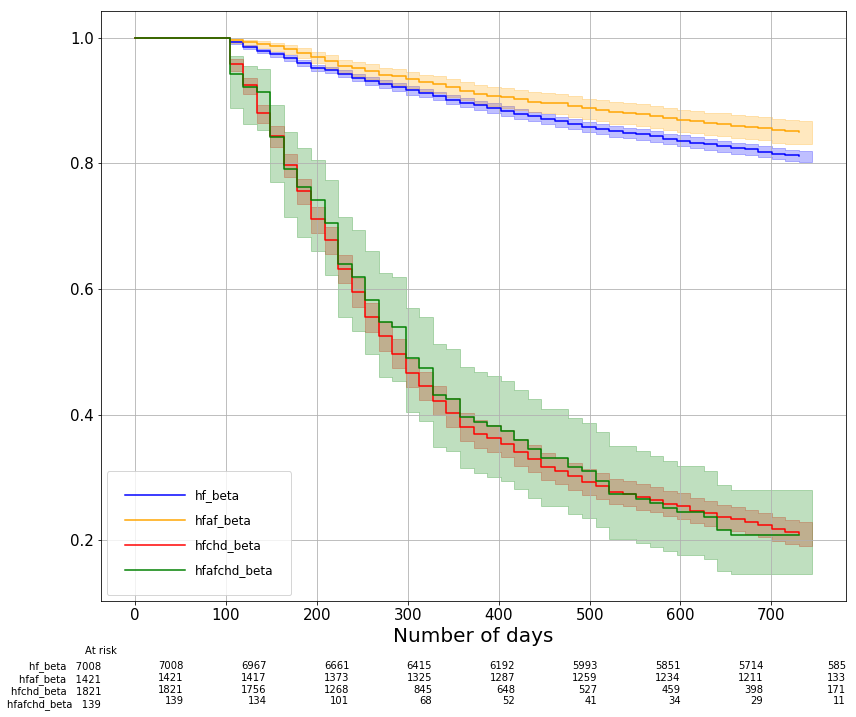

In [524]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hf_beta = KaplanMeierFitter()
ax = kmf_hf_beta.fit(T1, event_observed=E1, label='hf_beta', timeline=t).plot(ax=ax, color='blue')

kmf_hfaf_beta = KaplanMeierFitter()
ax = kmf_hfaf_beta.fit(T3, event_observed=E3, label='hfaf_beta', timeline=t).plot(ax=ax, color='orange')

kmf_hfchd_beta = KaplanMeierFitter()
ax = kmf_hfchd_beta.fit(T11, event_observed=E11, label='hfchd_beta', timeline=t).plot(ax=ax, color='red')

kmf_hfafchd_beta = KaplanMeierFitter()
ax = kmf_hfafchd_beta.fit(T6, event_observed=E6, label='hfafchd_beta', timeline=t).plot(ax=ax, color='green')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hf_beta, kmf_hfaf_beta, kmf_hfchd_beta, kmf_hfafchd_beta, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


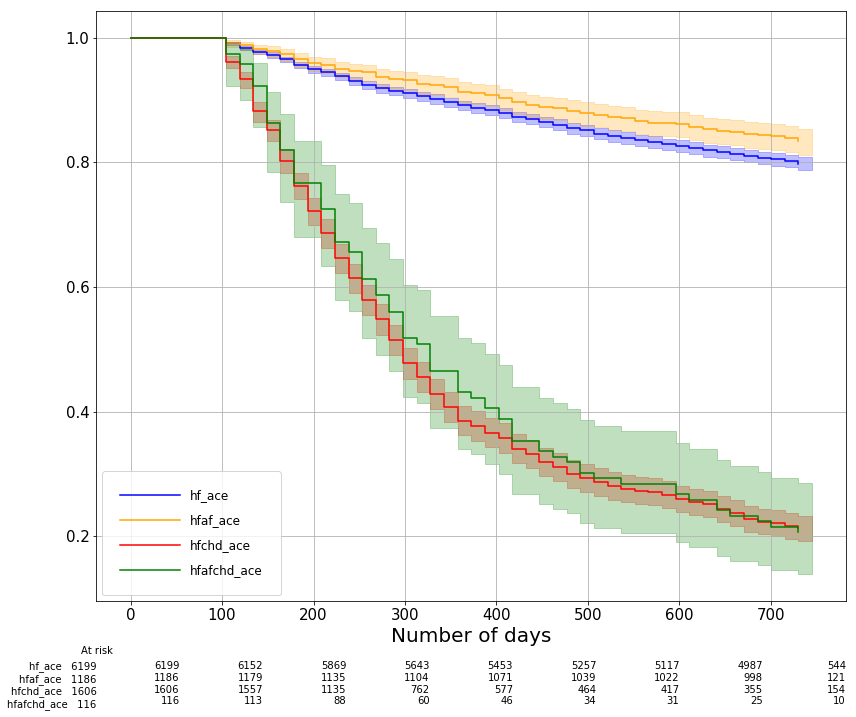

In [526]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)


kmf_hf_ace = KaplanMeierFitter()
ax = kmf_hf_ace.fit(T2, event_observed=E2, label='hf_ace', timeline=t).plot(ax=ax, color='blue')

kmf_hfaf_ace = KaplanMeierFitter()
ax = kmf_hfaf_ace.fit(T5, event_observed=E5, label='hfaf_ace', timeline=t).plot(ax=ax, color='orange')

kmf_hfchd_ace = KaplanMeierFitter()
kmf_hfchd_ace.fit(T12, event_observed=E12, label='hfchd_ace', timeline=t).plot(ax=ax, color='red')

kmf_hfafchd_ace = KaplanMeierFitter()
ax = kmf_hfafchd_ace.fit(T8, event_observed=E8, label='hfafchd_ace', timeline=t).plot(ax=ax, color='green')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hf_ace, kmf_hfaf_ace, kmf_hfchd_ace, kmf_hfafchd_ace, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


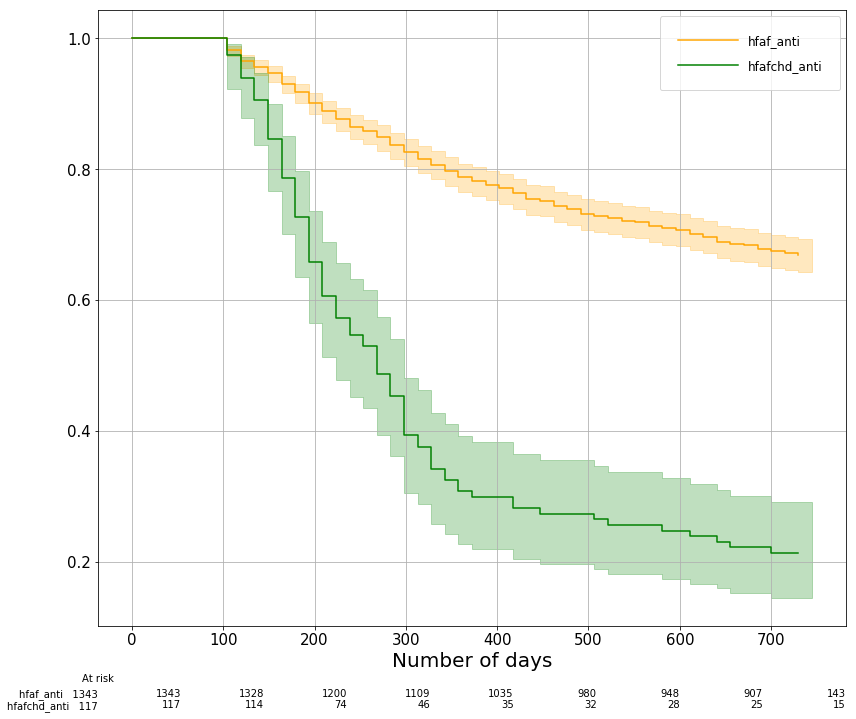

In [527]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hfaf_anti = KaplanMeierFitter()
ax = kmf_hfaf_anti.fit(T4, event_observed=E4, label='hfaf_anti', timeline=t).plot(ax=ax, color='orange')

kmf_hfafchd_anti = KaplanMeierFitter()
ax = kmf_hfafchd_anti.fit(T7, event_observed=E7, label='hfafchd_anti', timeline=t).plot(ax=ax, color='green')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hfaf_anti, kmf_hfafchd_anti, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


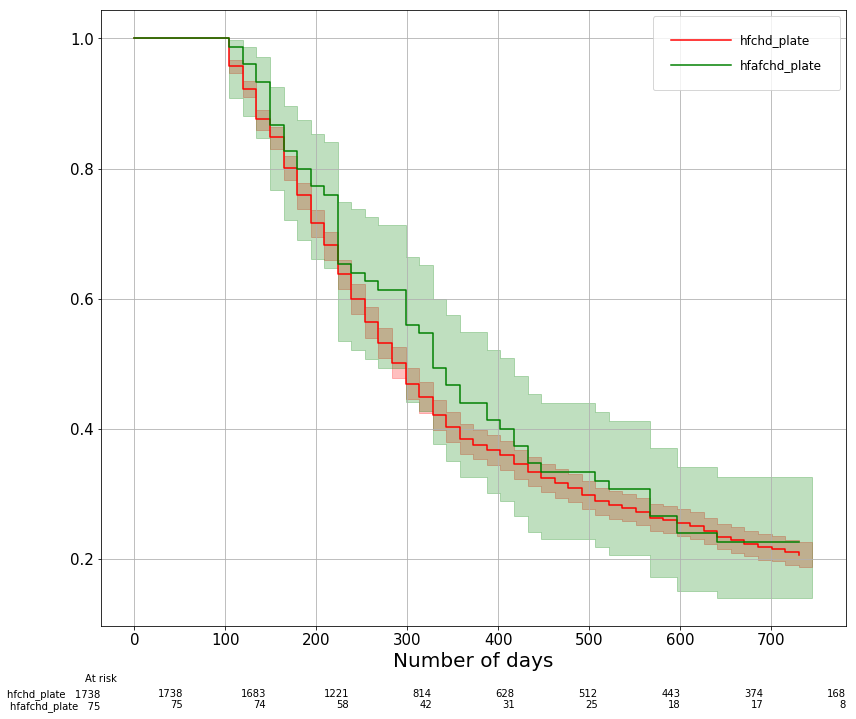

In [528]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hfchd_plate = KaplanMeierFitter()
ax = kmf_hfchd_plate.fit(T13, event_observed=E13, label='hfchd_plate', timeline=t).plot(ax=ax, color='red')

kmf_hfafchd_plate = KaplanMeierFitter()
ax = kmf_hfafchd_plate.fit(T9, event_observed=E9, label='hfafchd_plate', timeline=t).plot(ax=ax, color='green')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hfchd_plate, kmf_hfafchd_plate, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


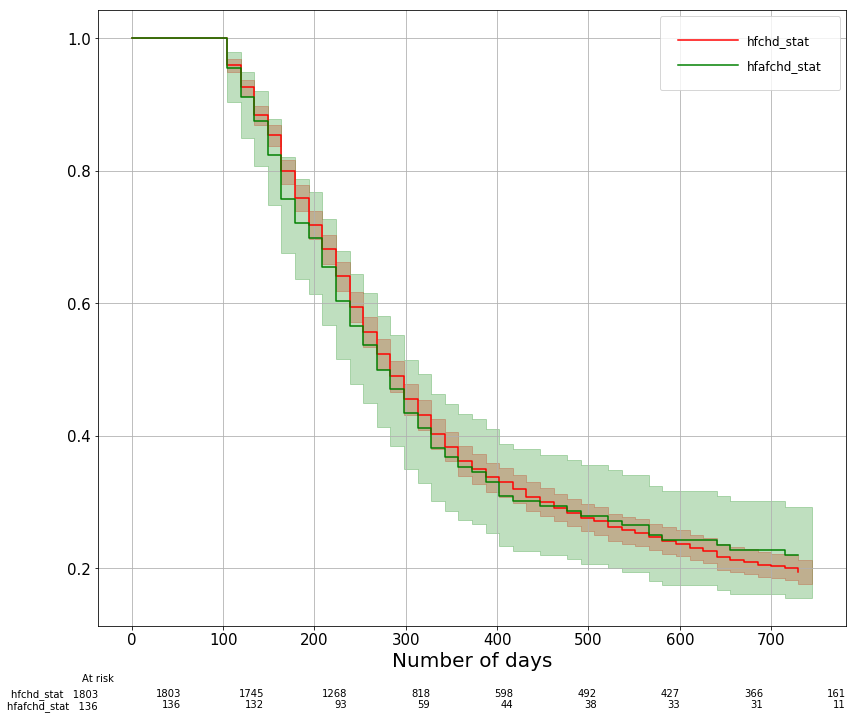

In [529]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hfchd_stat = KaplanMeierFitter()
kmf_hfchd_stat.fit(T14, event_observed=E14, label='hfchd_stat', timeline=t).plot(ax=ax, color='red')

kmf_hfafchd_stat = KaplanMeierFitter()
ax = kmf_hfafchd_stat.fit(T10, event_observed=E10, label='hfafchd_stat', timeline=t).plot(ax=ax, color='green')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hfchd_stat, kmf_hfafchd_stat, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


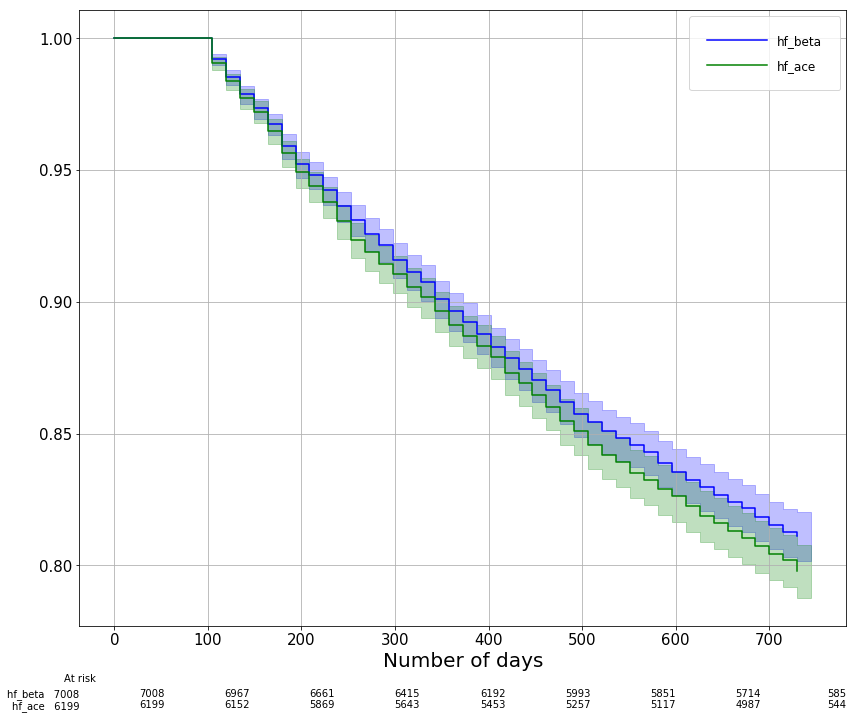

In [532]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hf_beta = KaplanMeierFitter()
ax = kmf_hf_beta.fit(T1, event_observed=E1, label='hf_beta', timeline=t).plot(ax=ax, color='blue')

kmf_hf_ace = KaplanMeierFitter()
ax = kmf_hf_ace.fit(T2, event_observed=E2, label='hf_ace', timeline=t).plot(ax=ax, color='green')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hf_beta, kmf_hf_ace, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


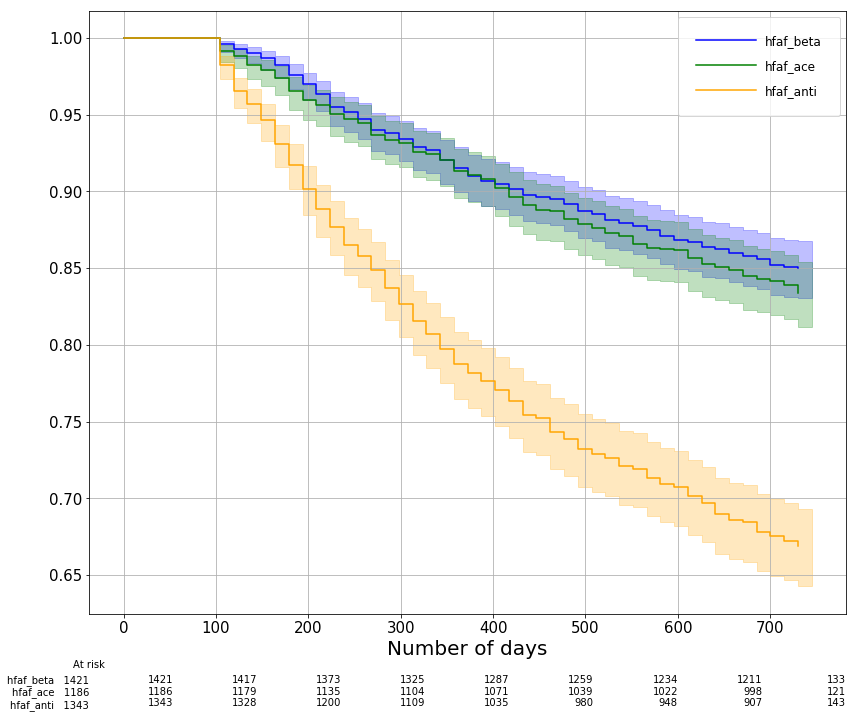

In [534]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hfaf_beta = KaplanMeierFitter()
ax = kmf_hfaf_beta.fit(T3, event_observed=E3, label='hfaf_beta', timeline=t).plot(ax=ax, color='blue')

kmf_hfaf_ace = KaplanMeierFitter()
ax = kmf_hfaf_ace.fit(T5, event_observed=E5, label='hfaf_ace', timeline=t).plot(ax=ax, color='green')

kmf_hfaf_anti = KaplanMeierFitter()
ax = kmf_hfaf_anti.fit(T4, event_observed=E4, label='hfaf_anti', timeline=t).plot(ax=ax, color='orange')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hfaf_beta, kmf_hfaf_ace, kmf_hfaf_anti, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


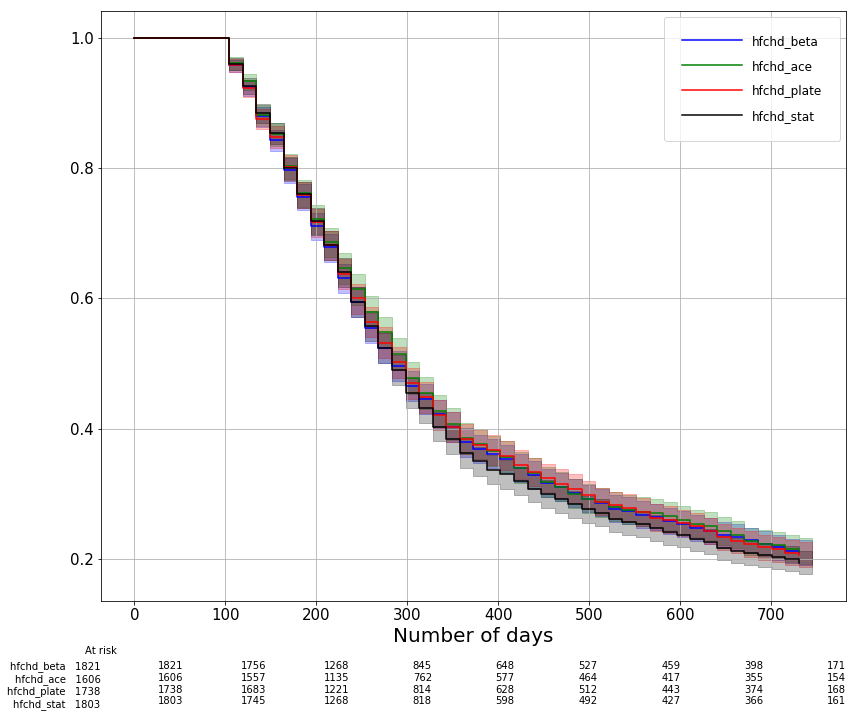

In [536]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hfchd_beta = KaplanMeierFitter()
ax = kmf_hfchd_beta.fit(T11, event_observed=E11, label='hfchd_beta', timeline=t).plot(ax=ax, color='blue')

kmf_hfchd_ace = KaplanMeierFitter()
kmf_hfchd_ace.fit(T12, event_observed=E12, label='hfchd_ace', timeline=t).plot(ax=ax, color='green')

kmf_hfchd_plate = KaplanMeierFitter()
ax = kmf_hfchd_plate.fit(T13, event_observed=E13, label='hfchd_plate', timeline=t).plot(ax=ax, color='red')

kmf_hfchd_stat = KaplanMeierFitter()
kmf_hfchd_stat.fit(T14, event_observed=E14, label='hfchd_stat', timeline=t).plot(ax=ax, color='black')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hfchd_beta, kmf_hfchd_ace, kmf_hfchd_plate, kmf_hfchd_stat, ax=ax)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

/Users/ivan/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


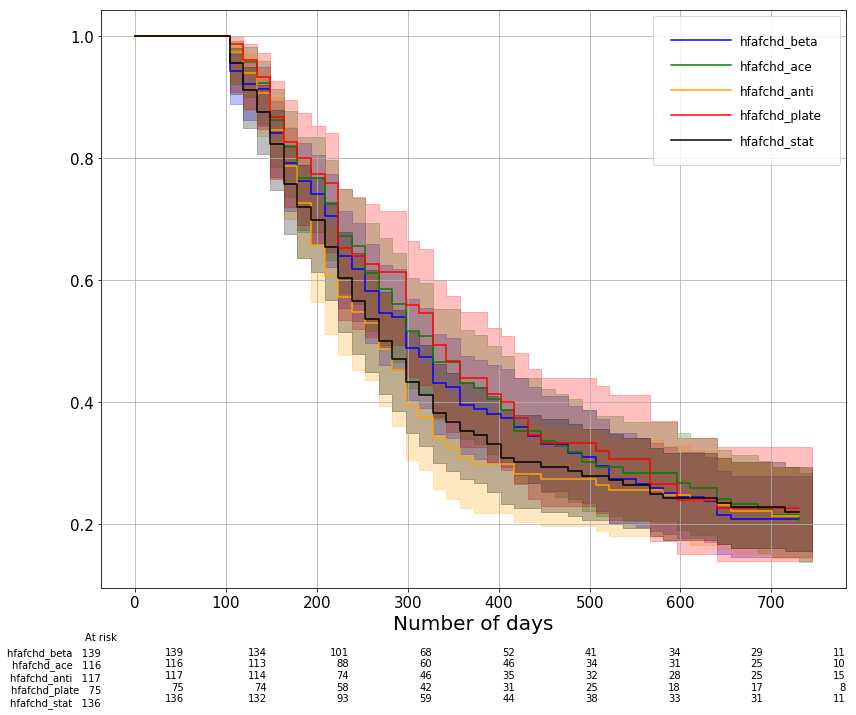

In [537]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)

kmf_hfafchd_beta = KaplanMeierFitter()
ax = kmf_hfafchd_beta.fit(T6, event_observed=E6, label='hfafchd_beta', timeline=t).plot(ax=ax, color='blue')

kmf_hfafchd_ace = KaplanMeierFitter()
ax = kmf_hfafchd_ace.fit(T8, event_observed=E8, label='hfafchd_ace', timeline=t).plot(ax=ax, color='green')

kmf_hfafchd_anti = KaplanMeierFitter()
ax = kmf_hfafchd_anti.fit(T7, event_observed=E7, label='hfafchd_anti', timeline=t).plot(ax=ax, color='orange')

kmf_hfafchd_plate = KaplanMeierFitter()
ax = kmf_hfafchd_plate.fit(T9, event_observed=E9, label='hfafchd_plate', timeline=t).plot(ax=ax, color='red')

kmf_hfafchd_stat = KaplanMeierFitter()
ax = kmf_hfafchd_stat.fit(T10, event_observed=E10, label='hfafchd_stat', timeline=t).plot(ax=ax, color='black')

from lifelines.plotting import add_at_risk_counts 
add_at_risk_counts(kmf_hfafchd_beta, kmf_hfafchd_ace, kmf_hfafchd_anti, kmf_hfafchd_plate, kmf_hfafchd_stat)

ax.set_xlabel('Number of days', fontsize='20')
ax.legend(borderpad=1.5, labelspacing=1, handlelength=5, fontsize='large')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.grid()

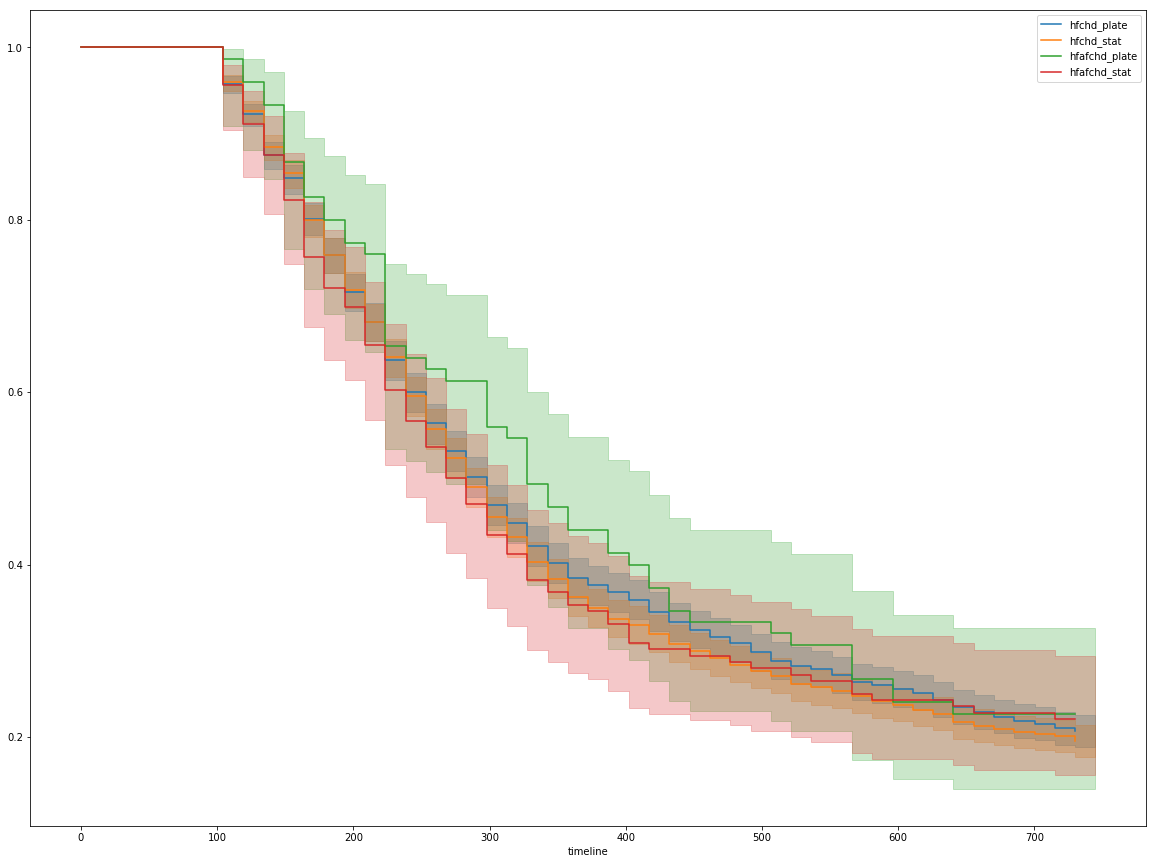

In [421]:
t = np.linspace(0, 730)

f = plt.figure(figsize=(20,15))
ax = f.add_subplot(111)

kmf_hfchd_plate = KaplanMeierFitter()
ax = kmf_hfchd_plate.fit(T13, event_observed=E13, label='hfchd_plate', timeline=t).plot(ax=ax)

kmf_hfchd_stat = KaplanMeierFitter()
kmf_hfchd_stat.fit(T14, event_observed=E14, label='hfchd_stat', timeline=t).plot(ax=ax)

kmf_hfafchd_plate = KaplanMeierFitter()
ax = kmf_hfafchd_plate.fit(T9, event_observed=E9, label='hfafchd_plate', timeline=t).plot(ax=ax)

kmf_hfafchd_stat = KaplanMeierFitter()
ax = kmf_hfafchd_stat.fit(T10, event_observed=E10, label='hfafchd_stat', timeline=t).plot(ax=ax)

In [422]:
from lifelines.statistics import logrank_test

results = logrank_test(T1, T3, E1, E3, alpha=0.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p    
        9.4755 0.0021  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [423]:
from lifelines.statistics import logrank_test

results = logrank_test(T2, T5, E2, E5, alpha=0.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p    
        7.0454 0.0079  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [424]:
from lifelines.statistics import logrank_test

results = logrank_test(T1, T6, E1, E6, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
      425.0039 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [425]:
from lifelines.statistics import logrank_test

results = logrank_test(T2, T8, E2, E8, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
      331.5123 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [426]:
from lifelines.statistics import logrank_test

results = logrank_test(T4, T7, E4, E7, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
      129.8609 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [427]:
from lifelines.statistics import logrank_test

results = logrank_test(T1, T2, E1, E2, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        3.5818 0.0584  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [428]:
from lifelines.statistics import logrank_test

results = logrank_test(T3, T5, E3, E5, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.9085 0.3405
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [429]:
from lifelines.statistics import logrank_test

results = logrank_test(T3, T4, E3, E4, alpha=.99)

results.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
      114.1398 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [430]:
from lifelines.statistics import logrank_test

results = logrank_test(T1, T2, E1, E2, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        3.5818 0.0584  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [431]:
from lifelines.statistics import logrank_test

results = logrank_test(T6, T8, E6, E8, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.0422 0.8373
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [432]:
from lifelines.statistics import logrank_test

results = logrank_test(T6, T7, E6, E7, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.5151 0.4730
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [433]:
from lifelines.statistics import logrank_test

results = logrank_test(T6, T9, E6, E9, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.2687 0.6042
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [434]:
from lifelines.statistics import logrank_test

results = logrank_test(T6, T10, E6, E10, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.0848 0.7708
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [435]:
from lifelines.statistics import logrank_test

results = logrank_test(T1, T11, E1, E11, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
     2709.5747 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [436]:
from lifelines.statistics import logrank_test

results = logrank_test(T2, T12, E2, E12, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
     2296.1979 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [437]:
from lifelines.statistics import logrank_test

results = logrank_test(T13, T9, E13, E9, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.4283 0.5128
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [438]:
from lifelines.statistics import logrank_test

results = logrank_test(T14, T10, E14, E10, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.1049 0.7461
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [439]:
from lifelines.statistics import logrank_test

results = logrank_test(T11, T12, E11, E12, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.0498 0.8235
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [440]:
from lifelines.statistics import logrank_test

results = logrank_test(T11, T13, E11, E13, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.0004 0.9846
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [441]:
from lifelines.statistics import logrank_test

results = logrank_test(T11, T14, E11, E14, alpha=.95)

results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.8024 0.3704
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
